In [1]:
## modified to handle 2018 CCAR dates (and balance truncation at last hist date for CCAR >= 2016) 
## 20160912: control actual balance history (12/2014 if ccar <= 2015; 12/2015 if ccar = 2016)
## master stress test module: includes state macro variables:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## lists of states and banks within regional group to analyze:
## state/region:  if none: stlst=[]; if one only: stlst=['FL']; if multiple states aggregated: stlst=['FL','GA','AL']
#stlst = ['FL','GA']
stlst = ['NV']
#stlst = ['CA']
#stlst=[]

## exclusion list: (enter IDRSSD for each bank to exclude)
#exlst = []  ## use this as default
#exlst = [2193616,665931,1212846]  ## FL,GA exclude: Raymond James, Northern Trust, Monogram Credit Card
exlst = [2502656,3150447,2129008,2036843,3287660,2819167] # NV: USAA, Chas Schwab, Household (SB & NA), Toyota, Farm Bureau
if len(exlst)==0:
  exflg = ''
else:
  exflg = 'x'

#########################################################################
## Pick one of the next 5 lines:  
irflg = '_NoRates'  ## use this to remove rates from regressions
#irflg = '_NoRate_Big3'  ## SPECIAL: designates backtest re-run using only "big 3" vars: UE, HPI, CRE
#irflg = '_NoRate_Big4v'  ## SPECIAL: designates backtest re-run using only "big 4" vars: UE, HPI, CRE, CE
#irflg = ''  ## use this to keep rates in regressions and use all variables in regressions
#irflg = '_Big3' ## use this to keep rates in regressions but limit vars to Big3 only

############################################################
# 12/13/15: new list: brief list of only vars to use in regressions
#   (Note: can be a small number other than 3 if desired... like 4 or 5)
#big3 = ['UE','HPI','CRE']  ### list of big3 variables
#big3 = ['UE','HPI','CRE','VIX']  ### list of big3 vars + VIX
big3=[]  ## use this if Big3 not selected

## WARNING:  Select small group of unique banks here:
rslst=[]  # IDRSSD list for ad hoc 
#rslst = [598534]  ## Fidelity (GA)
tclst=[]  # ticker list for ad hoc
#tclst = ['CCBG']  ## Capital City (FL)

##########################################################################
##  NOTE:  Large bank exclusions:  Pick one of 3 options:
##  'x00':  Include all banks (do not exclude any)
##  'x18':  Exclude CCAR 18-bank group and their acquired/merged banks
##  'x31':  Exclude CCAR 31-bank group and their acquired/merged banks
xtyp = 'x18'  ## pick 'x00', 'x18', or 'x31' only, (with grpC18, use x00 only)

htyp = ''  # use this for ultcert tickers (to catch acquired/consolidated banks in history)
#htyp = 'nohist' # use this for current affiliates only

## group name: select one line only among choices:
## (note: only one group can be specified, but all groups will be available for further analysis later!)
## (this label will be used to name all output files to make it easy to locate them later)
#grp = 'grp' + 'TotUS_C18C31' + xtyp + exflg + htyp # special code:
#grp = 'grp' + 'TotUS' + xtyp + exflg + htyp # use this for TotUS target group
#grp = 'grp' + 'C18' + xtyp + exflg + htyp # use this for C18 target group
#grp = 'grp' + 'C31' + xtyp + exflg + htyp # use this for C31 target group
grp = 'grp' + ''.join(stlst) + xtyp + exflg + htyp # use this for statelist (1, 2, or 3 states only)
#grp = 'grp' + 'CapFid_'+ ''.join(stlst) + xtyp + exflg + htyp # use this for any other grouping
#grp = 'grp' + 'CapFid' # use this for any other grouping (fill in a unique name into blanks)

USflg = 'Yes'  # 'Yes' means run TotUSx00,x18,x31 groups, 'No' means do not run all 3 TotUS groups
Cxflg = 'Yes'  # 'Yes' means run C18x00 and C31x00 groups, 'No' means do not run both of those groups
indiv = 'No'  # 'Yes' means run indiv banks/tickers, 'No' means do not run indiv banks/tickers

## flags for var transforms to use: orig, lag, exp
vtyp = 2  # 0: Original vars+CE, no transformations; 1: lags (UE,HPI,CRE,CE 4q lags); 2: Lags & sUE23
qtyp = 4  # 4: rolling 4q NCO rates, 1: 1qtr NCO rates (annualized)

if qtyp == 1:
  rtyp = "1q"
  rskp = 0
  curlst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']
elif qtyp == 4:
  rtyp = "4q"
  rskp = 3
  curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
else:
  rskp = 999
  rclst = []  # force error

cbo = ['Orig', 'Lags', 'Lags_sUE2']  # descriptors for vtyp code
styp = cbo[vtyp]  # selects one of the cbo codes based on vtyp entry.

grporig = grp
grp, styp, irflg

('grpNVx18x', 'Lags_sUE2', '_NoRates')

In [3]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

hs['DJ'] = hs['DJ']/1000
cc['DJ'] = cc['DJ']/1000

cc2 = cc.dropna(how='any',axis=1)  # remove any vars that are missing in any ccar year (removes T5y, Prime)
cccol = list(cc2.columns)[3:]
hs2 = hs[['Date']+cccol]
hs2.set_index('Date', drop=True, inplace=True)
hs2 = hs2.ix['2000-01':]
hscol = list(hs2.columns)  # original ccar variables

In [4]:
## Tickers to exclude from aggregates: CCAR 18-bank and 31-bank groups:
c18tic = ['ALLY','AXP','BAC','BBT','BK','C','COF','FITB','GS','JPM','KEY','MS','PNC','RF','STI','STT','USB','WFC']
c31tic = c18tic + ['BMO','BBVA','CFG','CMA','DB','DFS','HSBC','HBAN','MTB','MTU','NTRS','SAN','ZION']

In [5]:
#########################################################
## section to download CE and state CE & UE variables
#########################################################

In [6]:
## prepare to gather nominal GDP from FRED database:
start = pd.datetime(2000,1,1)
end = pd.datetime(2017,12,31)  # NOTE:  adjust this if processing 2016 or later quarters

In [7]:
if len(stlst) == 0:
  print("No states selected.")
else:
  print("OK to proceed.")

OK to proceed.


In [8]:
## process only if len(stlst)>0:
uestq = []
if len(stlst) > 0:
  uelst = [s + 'UR' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLUR' = FL unemp rate 
  lflst = [s + 'LF' for s in stlst]  ## codes in FRED database: 'FLLF' = FL labor force
  ## NOTE:  use labor force values as weightings for regional aggregates of state UE rates
  uest = web.DataReader(uelst+lflst,'fred',start,end)  ## download data in uest dataframe
  uest['UE_'+''.join(stlst)] = uest.apply(lambda x:np.average(x[[z+'UR' for z in stlst]],\
                                           weights=x[[z+'LF' for z in stlst]]),axis=1)
  uestq = uest.resample('Q').mean()

if len(uestq)>0:
  print(uestq.head(2))
else:
  print('No state UE')

                NVUR     NVLF     UE_NV
DATE                                   
2000-03-31  3.933333  1047397  3.933333
2000-06-30  4.033333  1059759  4.033333


In [9]:
celst = [] # CE codes for FRED database
telst = [] # TotEmployment codes for FRED database

if len(stlst)>0: celst = [s + 'CONS' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLCE' = FL constr emp
celst = ['USCONS'] + celst
if len(stlst)>0: telst = [s + 'NA' for s in stlst]  ## FLNA is Florida total non-farm employment
telst = ['PAYEMS'] + telst
cest = web.DataReader(celst+telst,'fred',start,end)  ## download data in uest dataframe
if len(stlst)>0:
  cest[''.join(stlst)+'CONS'] = cest.apply(lambda x:np.sum(x[[z+'CONS' for z in stlst]]),axis=1)
  cest[''.join(stlst)+'NA'] = cest.apply(lambda x:np.sum(x[[z+'NA' for z in stlst]]),axis=1)
cest[['USCONS','PAYEMS']] = cest[['USCONS','PAYEMS']].astype('float')
cestq = cest.resample('Q').mean()
cestq.ix['2014']

USCONS     NVCONS         PAYEMS         NVNA
DATE                                                          
2014-03-31  6009.666667  60.633333  137758.333333  1197.966667
2014-06-30  6107.666667  62.633333  138574.000000  1211.200000
2014-09-30  6204.666667  64.133333  139303.333333  1220.933333
2014-12-31  6273.000000  65.466667  140111.333333  1233.400000

In [10]:
cestq['CE'] = cestq['USCONS']*100 / cestq['PAYEMS']
if len(stlst)>0: cestq['CE_'+''.join(stlst)] = cestq[''.join(stlst)+'CONS']*100 / cestq[''.join(stlst)+'NA']
cestq.tail()

USCONS     NVCONS         PAYEMS         NVNA        CE  \
DATE                                                                       
2016-12-31  6806.666667  77.800000  145259.666667  1314.833333  4.685861   
2017-03-31  6904.666667  81.766667  145853.666667  1328.566667  4.733969   
2017-06-30  6927.000000  83.800000  146327.000000  1335.900000  4.733918   
2017-09-30  6955.666667  83.400000  146880.000000  1346.200000  4.735612   
2017-12-31  7030.000000  84.866667  147436.333333  1355.066667  4.768160   

               CE_NV  
DATE                  
2016-12-31  5.917100  
2017-03-31  6.154502  
2017-06-30  6.272925  
2017-09-30  6.195216  
2017-12-31  6.262914

In [11]:
if 'CE' not in list(hs2.columns): 
  hs2 = hs2.merge(cestq[['CE']],how='outer',left_index=True, right_index=True)
  if len(stlst)>0: 
    hs2 = hs2.merge(cestq[['CE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
    hs2 = hs2.merge(uestq[['UE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
hs2.tail()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T10y  BBB  Mort      DJ  \
Date                                                                           
2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4   2.2  4.1   3.8  23.277   
2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6   2.5  4.2   4.2  24.508   
2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9   2.3  4.0   4.0  25.125   
2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0   2.3  3.9   3.9  26.149   
2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2   2.4  4.0   3.9  27.673   

              HPI    CRE   VIX        CE     CE_NV     UE_NV  
Date                                                          
2016-12-31  184.0  269.0  22.5  4.685861  5.917100  5.400000  
2017-03-31  187.0  262.0  13.1  4.733969  6.154502  5.233333  
2017-06-30  190.0  272.0  16.0  4.733918  6.272925  5.100000  
2017-09-30  193.0  275.0  16.0  4.735612  6.195216  4.933333  
2017-12-31  194.0  279.0  13.1  4.768160  6.262914  4.900000

In [12]:
### remove all interest rate variables: (They interfere with scenario forecasts.)
xvr = ['Mort','T3m','T5y','T10y','Prime','BBB'] ## xvr: interest rate CCAR vars to exclude from regressions

### ALWAYS remove int rates for this set of regressions for CE ,CE_st and UE_st variables!!!!
cccol = [x for x in cccol if x not in xvr]  ## removes interest rate vars from cccol (ccar var columns)
cccol

['rGDPg', 'nGDPg', 'rDIg', 'nDIg', 'UE', 'CPI', 'DJ', 'HPI', 'CRE', 'VIX']

In [13]:
## 3-var models:
## hs2, cc2 have removed T5y and Prime since those are not in CCAR 2012 or 2013 variables
hsy = hs2.copy()
hsz = hs2.copy()
hsz['Intercept'] = 1.0
hsz.reset_index(drop=False,inplace=True)
ccs = cc2.copy()
ccs.sort_index(by=['Scen','Date'],inplace=True)
ccs['Intercept'] = 1.0
svlst = [x for x in list(hs2.columns) if x not in hscol]
curlst = svlst
topn = 1  # number of final models to review (use topn=1 for production)
topx = 2  # number of 2-var pairs to allow in final 3 for 3-var models
curlst

['CE', 'CE_NV', 'UE_NV']

In [14]:
### build 3-var models:

In [15]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [16]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [17]:
# function to select topn models for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))


In [18]:
df3b.to_csv(grp+"_3var_stvar_params.csv")

In [19]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [20]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 3-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 4-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 4-var models
df4b.index = np.arange(len(df4b))


In [21]:
df4b.to_csv(grp+"_4var_stvar_params.csv")
df4b

rc  v1        r1  v2        r2   v3        r3   v4        r4        Int  \
0     CE  UE  0.503717  DJ  0.835079  HPI  0.952758  CPI  0.954263   6.136625   
1  CE_NV  UE  0.320119  DJ  0.784387  HPI  0.934925  VIX  0.939961  14.016801   
2  UE_NV  UE  0.899587  DJ  0.941241  HPI  0.957940  CRE  0.964597  -3.122076   

         c1        c2        c3        c4  
0 -0.216086 -0.081251  0.007952  0.010031  
1 -0.874698 -0.471468  0.041044 -0.017922  
2  1.740549  0.132804 -0.034668  0.015175

In [22]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs[rc] = p_tot


In [23]:
ccp = ccs[ccs.Scen.isin(['Bas','Sev'])].copy()
ccp['yrscen'] = ccp.apply(lambda x: str(x['CCAR'])[-2:]+'_'+x['Scen'],axis=1)
ccp.sort_index(by=['CCAR','Scen','Date'],inplace=True)
ccp.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m   ...    \
278  2018  Sev 2020-12-31    4.5    5.5   3.1   4.3  8.9  1.6  0.1   ...     
279  2018  Sev 2021-03-31    4.5    5.4   3.3   4.5  8.6  1.5  0.1   ...     

     Mort      DJ    HPI    CRE   VIX  Intercept        CE     CE_NV  \
278   4.9  18.143  141.0  176.0  15.0        1.0  3.876559  3.196448   
279   4.7  20.168  143.0  180.0  14.4        1.0  3.791752  2.596975   

         UE_NV  yrscen  
278  12.560953  18_Sev  
279  12.299081  18_Sev  

[2 rows x 22 columns]

In [24]:
svlst

['CE', 'CE_NV', 'UE_NV']

In [25]:
cc[cc['CCAR']==2015].tail()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
149  2015  Sev 2016-12-31    3.0    4.3   1.8   3.3  9.9  1.9  0.1  0.9   1.9   
150  2015  Sev 2017-03-31    3.9    5.2   2.7   4.2  9.7  1.9  0.1  1.1   2.0   
151  2015  Sev 2017-06-30    3.9    5.2   2.8   4.1  9.5  1.7  0.1  1.2   2.1   
152  2015  Sev 2017-09-30    3.9    5.1   2.9   4.2  9.3  1.6  0.1  1.3   2.2   
153  2015  Sev 2017-12-31    3.9    5.1   3.0   4.3  9.1  1.6  0.1  1.5   2.3   

     BBB  Mort  Prime       DJ    HPI    CRE   VIX  
149  5.5   4.7    3.2  11.5214  128.4  154.6  21.6  
150  5.3   4.7    3.2  12.8947  127.9  156.1  18.7  
151  5.2   4.7    3.2  14.0792  128.4  159.6  17.6  
152  5.1   4.7    3.2  15.4303  129.5  164.0  16.4  
153  5.1   4.7    3.2  16.4876  131.0  169.1  16.5

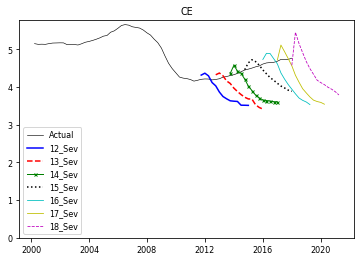

In [26]:
i = 0  ## enter 0, 1, or 2 only (for 3 items in svlst)
gr = pd.DataFrame(hsy[svlst[i]])
gr.rename(columns={svlst[i]:'Actual'},inplace=True)
cp3 = ccp[['yrscen','Date',svlst[i]]]
cp3 = cp3.pivot('Date','yrscen',svlst[i])

gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)
xa = list(gr3.index)

plt.rcParams.update({'font.size': 8})
plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
#plt.plot(xa, gr3['12_Bas'],c='b',ls=':',lw=1.3,label="12_Bas")
plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
#plt.plot(xa, gr3['13_Bas'],c='r',ls=':',lw=1.3,label="13_Bas")
plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
#plt.plot(xa, gr3['14_Bas'],c='g',ls=':',lw=1.3,label="14_Bas")
plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
#plt.plot(xa, gr3['15_Bas'],c='k',ls=':',lw=1.3,label="15_Bas")
plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
plt.title(svlst[i])
plt.ylim(ymin=0)
if svlst[i][0:2] == 'CE':
  lc = 3
else:
  lc = 2
plt.legend(loc=lc) # 2 (UE) or 3 (CE)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
svlst2 = svlst + ['UE']
svlst2.sort()
svlst2

['CE', 'CE_NV', 'UE', 'UE_NV']

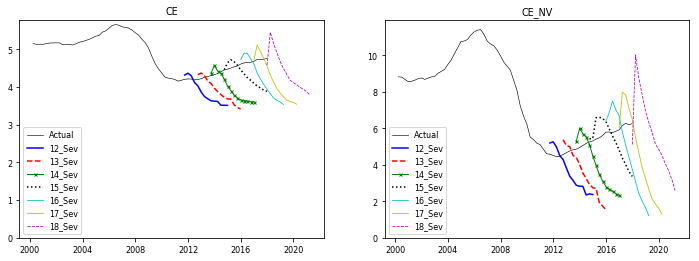

In [28]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=0  ## 0 or 2 only
for i in np.arange(2):
  plt.subplot(1, 2, i+1)
  gr = pd.DataFrame(hsy[svlst2[i+j]])
  gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
  cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
  cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

  gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

  plt.rcParams.update({'font.size': 8})
  plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
  plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
  plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
  plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
  plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
  plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
  plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
  plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
  plt.title(svlst2[i+j])
  plt.legend(loc=0)
  plt.ylim(ymin=0)

plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
"Var"+svlst2[i+j]+'_4var.png',

('VarCE_NV_4var.png',)

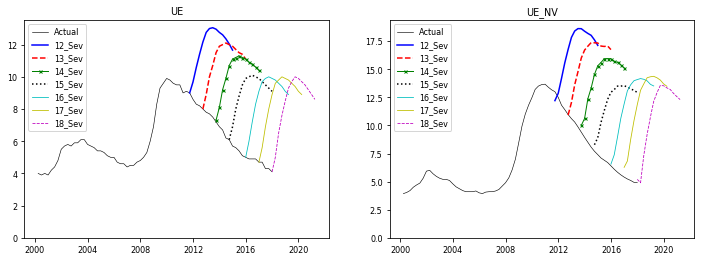

In [30]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=2  ## 0 or 2 only
if len(svlst2)==4:
  for i in np.arange(2):
    plt.subplot(1, 2, i+1)
    gr = pd.DataFrame(hsy[svlst2[i+j]])
    gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
    cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
    cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

    gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

    plt.rcParams.update({'font.size': 8})
    plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
    plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
    plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
    plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
    plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
    plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
    plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
    plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
    plt.title(svlst2[i+j])
    plt.legend(loc=0)
    plt.ylim(ymin=0)

if len(svlst2)== 4:
  plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('No output...')

In [31]:
stcol = [x for x in list(hs2.columns) if x not in list(hs.columns)]  ## list of new variables to process
stcol

['CE', 'CE_NV', 'UE_NV']

In [32]:
## add new state and CE columns to original history variable table ('hs'), call it hs3
if len(stcol)>0:
  hs3 = hs.copy()
  hs3.set_index('Date',drop=True,inplace=True)
  hs3 = hs3.ix['2000':]
  hs3 = hs3.merge(hs2[stcol],how='left',left_index=True,right_index=True)

hs3.head(2)

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
Date                                                                        
2000-03-31    1.2    4.3   8.1  11.8  4.0  4.0  5.5  6.6   6.7  8.2   8.3   
2000-06-30    7.8   10.2   4.2   6.1  3.9  3.2  5.7  6.5   6.4  8.5   8.3   

            Prime      DJ    HPI    CRE   VIX        CE     CE_NV     UE_NV  
Date                                                                         
2000-03-31    8.7  14.296  102.0  127.0  27.0  5.153778  8.821977  3.933333  
2000-06-30    9.2  13.619  105.0  125.0  33.5  5.135624  8.802690  4.033333

In [33]:
## add new state and CE columns to original ccar variable table ('cc'), call it cc3:
if len(stcol)>0:
  cc3 = cc.copy()
  cc3.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  cc3 = cc3.merge(ccs[['CCAR','Scen','Date']+stcol],how='left',on=['CCAR','Scen','Date'])

cc3.head(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0    ...       
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1    ...       

    BBB  Mort  Prime        DJ     HPI     CRE    VIX        CE     CE_NV  \
0  4.90  4.20    NaN  11.67700  132.00  177.00  48.00  4.318785  5.196659   
1  4.52  4.21    NaN  11.93609  137.21  172.17  35.97  4.310532  5.416480   

       UE_NV  
0  12.203483  
1  12.158031  

[2 rows x 22 columns]

In [34]:
hs3.to_csv(grp+'_histvars.csv')
cc3.to_csv(grp+'_ccarvars.csv')

In [35]:
## end of state variable (and CE) processing... move onto gathering bank data

In [36]:
## gather Call Rpt data for requested groups:

In [37]:
## process Call Rpt data for requested banks:
## rk table will be used to find identifiers (and associated acquired banks for BHCs)
if htyp == 'nohist':
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_nohist201712.csv", index_col=0)  # 20160508 nohist version
else:
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201712.csv", index_col=0)  # fixed 3 dup tickers (FBMS,FCBC,RBCAA)

rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
htyp

''

In [38]:
rk['C18'] = 'No'
rk['C31'] = 'No'
#c18tic
rk.loc[rk.Ticker.isin(c18tic), 'C18']='C18'
rk.loc[rk.Ticker.isin(c31tic), 'C31']='C31'

In [39]:
b18 = set(list(rk[rk['C18']=='C18']['IDRSSD']))  ## C18 banks 
b31 = set(list(rk[rk['C31']=='C31']['IDRSSD']))  ## C31 banks 

len(b18), len(b31), len(exlst) # 446, 609, 6

(446, 609, 6)

In [40]:
############ CAUTION
############ CAUTION

In [41]:
## CAUTION:  DO NOT RE-RUN THIS CELL if it was run earlier in session (wastes a lot of time)
## read Call Report extract file for all banks:
dg2 = pd.read_csv("df2_2001_201712.csv")
dg2['AsOf'] = pd.to_datetime(dg2['AsOf'])

fcol = dg2.columns[5:]  ## get listing of numeric fields, then...
dg2[fcol] = dg2[fcol].astype(float)  ### CRITICAL to convert numeric data to FLOAT!!! (since some are ints)

In [42]:
dcol = list(dg2)[5:]  ## data column names
dcol[0:5]

['Cert', 'eTotAst', 'eTotLn', 'eALLL', 'eOREO']

In [43]:
## grpTotUSx00:
px00 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px00 = dg2[['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px00n = dg2[['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px00n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px00 = pd.concat([px00n,px00], join='inner', axis=1)
  px00 = px00.reset_index(drop=False)
  px00['IDRSSD'] = 0
  px00['Grp'] = 'grp' + 'TotUS' + 'x00' + htyp
  px00 = px00[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px00)

68

In [44]:
## grpTotUSx18:
px18 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px18 = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px18n = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px18 = pd.concat([px18n,px18], join='inner', axis=1)
  px18 = px18.reset_index(drop=False)
  px18['IDRSSD'] = 0
  px18['Grp'] = 'grp' + 'TotUS' + 'x18' + htyp
  px18 = px18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px18)

68

In [45]:
## grpTotUSx31:
px31 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px31 = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px31n = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px31 = pd.concat([px31n,px31], join='inner', axis=1)
  px31 = px31.reset_index(drop=False)
  px31['IDRSSD'] = 0
  px31['Grp'] = 'grp' + 'TotUS' + 'x31' + htyp
  px31 = px31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px31)

68

In [46]:
#C18 processing:
pcx18=[]
if ('C18' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx18 = dg2[dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx18n = dg2[dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx18 = pd.concat([pcx18n,pcx18], join='inner', axis=1)
  pcx18 = pcx18.reset_index(drop=False)
  pcx18['IDRSSD'] = 0
  pcx18['Grp'] = 'grpC18x00'
  pcx18 = pcx18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx18)

68

In [47]:
# C31 processing:
pcx31=[]
if ('C31' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx31 = dg2[dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx31n = dg2[dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx31 = pd.concat([pcx31n,pcx31], join='inner', axis=1)
  pcx31 = pcx31.reset_index(drop=False)
  pcx31['IDRSSD'] = 0
  pcx31['Grp'] = 'grpC31x00'
  pcx31 = pcx31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx31)

68

In [48]:
## state level aggregates: # 20160414:  run x00
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
pxstx00 = []
if len(stlst)>0:
  xt = 'x00'
  stx = []
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  if len(stx)==0: strs = [x for x in strs]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx00 = pxst.copy()

len(pxstx00)

68

In [49]:
stlst

['NV']

In [50]:
## state level aggregates: # 20160414:  run x18x
pxstx18x=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0)&(exflg=='x'):
  xt = 'x18'
  stx = list(b18) + exlst
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + exflg + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18x = pxst.copy()

len(pxstx18x)

68

In [51]:
## state level aggregates: # 20160414:  run x18
pxstx18=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
if (len(stlst)>0):
  xt = 'x18'
  stx = list(b18) 
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt  + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18 = pxst.copy()

len(pxstx18)

68

In [52]:
prd='eTotLn'
dgp5=[]

if len(stlst)>0:
  dgp = dg2[(dg2[prd]>0)&(dg2.State.isin(stlst))][['IDRSSD','Name','AsOf',prd]]
  dgp.sort_index(by=['IDRSSD',prd],ascending=[True,False],inplace=True)

  dgp.sort_index(by=['IDRSSD','AsOf'],inplace=True)
  dgp5 = dgp.ix[dgp.groupby(['IDRSSD']).apply(lambda x: x[prd].idxmax())]
  dgp5 = dgp5.merge(rk[['IDRSSD','Ticker','C18','C31','xState','xCert','xAsOf']],how='left',on='IDRSSD')
  dgp5.sort_index(by=[prd],ascending=False,inplace=True)
  dgp5.to_csv(grp+"_"+prd+"_maxbal.csv")

if len(dgp5)>20: dpg5=dgp5[0:20]
    
dgp5

IDRSSD                                 Name       AsOf       eTotLn  \
7    476810                       CITIBANK, N.A. 2008-03-31  693929000.0   
5    455365                CITIBANK (NEVADA), NA 2004-06-30   17147208.0   
39  3150447                  CHARLES SCHWAB BANK 2017-12-31   16660000.0   
20  2502656                    USAA SAVINGS BANK 2013-09-30   16144704.0   
0    131360                  FIRST REPUBLIC BANK 2007-06-30    9323747.0   
9    655576          WELLS FARGO BANK NEVADA, NA 2003-03-31    9017057.0   
10  1225761  WELLS FARGO FINANCIAL NATIONAL BANK 2017-09-30    7726602.0   
13  2129008              HOUSEHOLD BANK (SB), NA 2001-03-31    5358017.0   
40  3284397                        BEAL BANK USA 2017-09-30    4073592.0   
6    456960                    NEVADA STATE BANK 2006-09-30    3289072.0   
3    411464        FIRST NATIONAL BANK OF NEVADA 2008-06-30    3184840.0   
14  2197098                       BANK OF NEVADA 2013-06-30    2416298.0   
19  2479310                    SILVER STATE BANK 2008-06-30    1639110.0   
15  2319676             COMMUNITY BANK OF NEVADA 2008-06-30    1394823.0   
11  2036843          HOUSEHOLD BANK (NEVADA), NA 2002-06-30    1095916.0   
41  3287660        TOYOTA FINANCIAL SAVINGS BANK 2013-12-31     874425.0   
27  2819167                 FARM BUREAU BANK FSB 2016-09-30     803348.0   
53  3719648                         MEADOWS BANK 2017-12-31     682144.0   
16  2349301              HERITAGE BANK OF NEVADA 2017-09-30     546581.0   
38  3077629                 NEVADA SECURITY BANK 2007-09-30     488794.0   
23  2646523                    NEVADA FIRST BANK 2006-03-31     407663.0   
17  2352815              BUSINESS BANK OF NEVADA 2006-12-31     393649.0   
29  2849829     FIRST INDEPENDENT BANK OF NEVADA 2010-06-30     381905.0   
24  2714570                        SUN WEST BANK 2008-06-30     377026.0   
30  2856032                    BANK OF LAS VEGAS 2010-03-31     359554.0   
25  2737038                          VALLEY BANK 2006-06-30     331658.0   
43  3385324           TOWN NORTH BANK NEVADA, NA 2008-12-31     306506.0   
8    639567         FIRST NATIONAL BANK OF MARIN 2001-12-31     268238.0   
32  2901688                SECURITY SAVINGS BANK 2007-03-31     225287.0   
33  2914718                       BANK OF NEVADA 2005-12-31     217403.0   
35  3023701                    SOUTHWESTUSA BANK 2009-06-30     186722.0   
37  3067929                  TOWN & COUNTRY BANK 2008-06-30     178794.0   
12  2068134           GREAT BASIN BANK OF NEVADA 2008-09-30     154609.0   
46  3550896            SERVICE1ST BANK OF NEVADA 2009-09-30     147429.0   
31  2896298                 NEVADA COMMERCE BANK 2009-06-30     136285.0   
47  3555248        FIRST SECURITY BANK OF NEVADA 2017-06-30     131528.0   
52  3636446                       BANK OF GEORGE 2017-12-31     130227.0   
34  2950668                 NORTHERN NEVADA BANK 2005-12-31     126485.0   
22  2626815                     BANK OF COMMERCE 2005-03-31     121379.0   
28  2848037              RED ROCK COMMUNITY BANK 2008-12-31     110845.0   
26  2808787                DESERT COMMUNITY BANK 2008-03-31      92448.0   
42  3370357                VALLEY BANK OF NEVADA 2017-06-30      83439.0   
36  3049653                    BANK OF LAS VEGAS 2008-03-31      66362.0   
54  3720336              KIRKWOOD BANK OF NEVADA 2017-09-30      66305.0   
2    400767        NEVADA BANK AND TRUST COMPANY 2008-03-31      61447.0   
44  3437081          CARSON RIVER COMMUNITY BANK 2009-12-31      39536.0   
45  3465383                    1ST COMMERCE BANK 2009-06-30      38420.0   
51  3604155                     FIRST ASIAN BANK 2009-03-31      33346.0   
18  2442583                  MESQUITE STATE BANK 2002-03-31      32687.0   
49  3589588                 NEVADA NATIONAL BANK 2009-06-30      25897.0   
21  2605566               EAGLEMARK SAVINGS BANK 2015-06-30      24794.0   
4    450669      FIRST NATIONAL BANK OF ELY, THE 2009

In [53]:
# process requested tickers and IDRSSDs:
pxbk = []
if (len(tclst)>0)&(indiv=='Yes'):
  bkrs=rslst+list(rk[rk['Ticker'].isin(tclst)]['IDRSSD'])
  bknm=list(rk[rk['IDRSSD'].isin(bkrs)]['xName'])
  pxbk = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxbkn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxbkn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxbk = pd.concat([pxbkn,pxbk], join='inner', axis=1)
  pxbk = pxbk.reset_index(drop=False)
  pxbk['IDRSSD'] = 0
  pxbk['Grp'] = grp
  pxbk = pxbk[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pxbk), grp

(0, 'grpNVx18x')

In [54]:
# rslst processing:
pxri = []
if (len(rslst)>0)&(indiv=='Yes'):
  for i in np.arange(len(rslst)):
    bknm=rk[rk['IDRSSD']==rslst[i]]['xName']
    pxrj = dg2[dg2['IDRSSD']==rslst[i]][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxrjn = dg2[dg2['IDRSSD']==rslst[i]][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxrjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxrj = pd.concat([pxrjn,pxrj], join='inner', axis=1)
    pxrj = pxrj.reset_index(drop=False)
    pxrj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()]) + str(i)
    pxrj['IDRSSD'] = rslst[i]
    pxrj = pxrj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxri = pxrj.copy()
    else:
      pxri = pd.concat([pxri,pxrj],ignore_index=True)

len(pxri)

0

In [55]:
# tclst processing:  ## 20160505: handles multiple tickers in tclst!!
pxci = []
if (len(tclst)>0)&(indiv=='Yes'):
  # create dict for ParRSSD:
  tcd = dict([(i, x) for i, x in zip(rk[rk.Ticker.isin(tclst)].Ticker, rk.ParRSSD)])
  for i in np.arange(len(tclst)):
    bkrs=list(rk[rk['Ticker'].isin([tclst[i]])]['IDRSSD'])
    bknm=(rk[rk['IDRSSD']==bkrs[i]]['Parent'])
    pxcj = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxcjn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxcjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxcj = pd.concat([pxcjn,pxcj], join='inner', axis=1)
    pxcj = pxcj.reset_index(drop=False)
    pxcj['IDRSSD'] = tcd[tclst[i]]
    pxcj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()[0:3]]) + str(i)
    pxcj = pxcj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxci = pxcj.copy()
    else:
      pxci = pd.concat([pxci,pxcj],ignore_index=True)

len(pxci)

0

In [56]:
pxlst = [px00,px18,px31,pcx18,pcx31,pxstx00,pxstx18,pxstx18x,pxbk,pxri,pxci]
pxz = pd.concat([x for x in pxlst if len(x)>0])
gpxz = list(pxz[['Grp','AsOf']].groupby('Grp').count().index)
len(pxz), gpxz

(544,
 ['grpC18x00',
  'grpC31x00',
  'grpNVx00',
  'grpNVx18',
  'grpNVx18x',
  'grpTotUSx00',
  'grpTotUSx18',
  'grpTotUSx31'])

In [57]:
pxz[['Grp','nbr']].groupby('Grp').count()

nbr
Grp             
grpC18x00     68
grpC31x00     68
grpNVx00      68
grpNVx18      68
grpNVx18x     68
grpTotUSx00   68
grpTotUSx18   68
grpTotUSx31   68

In [58]:
pxz2 = pxz[['Grp','nbr']].groupby('Grp').mean()
pxz2

nbr
Grp                     
grpC18x00     131.147059
grpC31x00     192.838235
grpNVx00       28.764706
grpNVx18       26.852941
grpNVx18x      23.264706
grpTotUSx00  7418.294118
grpTotUSx18  7287.147059
grpTotUSx31  7225.455882

In [59]:
grplst = list(pxz2.index)
grplst

['grpC18x00',
 'grpC31x00',
 'grpNVx00',
 'grpNVx18',
 'grpNVx18x',
 'grpTotUSx00',
 'grpTotUSx18',
 'grpTotUSx31']

In [60]:
## set up processing tables for calcs:
df3 = pxz.copy()  # set up for calc processing using old table names
df3.sort_index(by=['Grp','IDRSSD','AsOf'],inplace=True)  ## added 12/24/15

df3['mn'] = df3['AsOf'].map(lambda x: x.month)  ## add separate month col to ease calcs converting YTDs to qtrly vals

df3a = df3[['Grp','IDRSSD','AsOf','mn']]  # table used to run calcs
df3z = df3[['Grp','IDRSSD','AsOf']]  # table to hold calc results

In [61]:
dct = { 3 : 0, 6 : 1/2 , 9 : 2/3, 12 : 3/4 }

# fn to adjust 1st row of each bank... 
# modified to use dict "dct" to speed processing:
def qa(x):
  if x['mn'] == 3: return 0
  if pd.isnull(x['x_1']):
    return dct[x['mn']] * x['x']
  else: 
    return x['x_1']

def q_calc(xi, xc):
  # calc Call Data into quarterly values from YTD values
  df3a['x'] = df3[xi]
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xi].shift(1)
  df3a['x_1'] = df3a.apply(qa, axis=1)
  df3a['xq'] = df3a['x'] - df3a['x_1']
  df3z[xc] = df3a['xq']
  return

In [62]:
q_calc('isNetInc', 'qNetInc')
q_calc('iiNetII', 'qNetII')
q_calc('isProv', 'qProv')
q_calc('isTotNII', 'qNonII')
q_calc('isTotNIE', 'qNonIE')
q_calc('isOREOgl', 'qOREOgl')    # 20160501
q_calc('isIntangExp', 'qIntangExp')

df3z['qRev'] = df3z['qNetII'] + df3z['qNonII']
df3z['qCashExp'] = df3z['qNonIE'] - df3z['qIntangExp']

q_calc('iiTotII', 'qiTotII')  # 20160320
q_calc('iiTotLn', 'qiTotLn')
q_calc('iiRE', 'qiRE')
q_calc('iiCI', 'qiCI')
q_calc('iiCard', 'qiCard')
q_calc('iiOthCsmr', 'qiOthCsmr')
q_calc('iiLeas','qiLeas')

df3z['qiTotLnLs'] = df3z['qiTotLn']+df3z['qiLeas']  #  20160320
df3z['qiOthLnLs'] = df3z['qiTotLnLs'] - df3z['qiRE'] - df3z['qiCI'] - df3z['qiCard'] - df3z['qiOthCsmr']  # 20160320

q_calc('iiDFIB', 'qiDFIB')
q_calc('iiTreas', 'qiTreas')
q_calc('iiMBS', 'qiMBS')
q_calc('iiOSec', 'qiOSec')
q_calc('iiFFS', 'qiFFS')
q_calc('iiOAstIB','qiOAstIB') # 20160320
q_calc('iiTotSec','qiTotSec') # 20160320
#df3z['qiTotSec'] = df3z['qiTreas'] + df3z['qiMBS'] + df3z['qiOSec']  # 20160320

q_calc('ieTotIE', 'qeTotIE') # 20160320
q_calc('ieNOW', 'qeNOW')
q_calc('ieSav', 'qeSav')
q_calc('ieCDun', 'qeCDun')
q_calc('ieCDov', 'qeCDov')
q_calc('ieFFP', 'qeFFP')
q_calc('ieFDepIB', 'qeFDepIB') ## 20160320
q_calc('ieDepIB', 'qeDepIB') ## 20160320

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ieOthBorr'] + df3['ieNote']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ieOthBorr'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ieNote'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qeBorr'] = df3a['xq']

q_calc('ieOLbIB','qeOLbIB') # 20160320

q_calc('ncoTotLn', 'qncTotLn')
q_calc('ncoCx', 'qncCx')
q_calc('ncoSfRev', 'qncSfRev')
q_calc('ncoSfTD', 'qncSfTD')
q_calc('ncoMult', 'qncMult')
q_calc('ncoCRE', 'qncCRE')
q_calc('ncoCIdom', 'qncCIdom')
q_calc('ncoCIfor', 'qncCIfor')
q_calc('ncoCard', 'qncCard')

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ncoAuto'] + df3['ncoOthCsmr']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ncoAuto'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ncoOthCsmr'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qncOthCsmr'] = df3a['xq']

df3z['qncCREtot'] = df3z['qncCx'] + df3z['qncMult'] + df3z['qncCRE']  # to match CCAR results categories
#df3['eCREtot'] = df3['eCx'] + df3['eMult'] + df3['eCRE']  # to match CCAR results categories

In [63]:
def y_calc(xn, xd, xc):  # quarterly yield calc (annualized):
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3z[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*400 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def r_calc(xn, xd, xc):  # rolling 4q yield calc:
  # calc rolling 4q items: yields, rates, nco rates
  df3a['x'] = df3z.groupby(['Grp','IDRSSD'])[xn].apply(pd.rolling_sum, 4, min_periods=4)
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xd].apply(pd.rolling_mean, 4, min_periods=4)
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def qn_calc(xn, xd, xc):  # quarterly non-accrual ratio calc:
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [64]:
y_calc('qNetII', 'aEarnAst', 'qyNetII') # 20160329
y_calc('qiTotII', 'aEarnAst', 'qyTotII') # 20160329
y_calc('qiTotLn', 'aTotLn', 'qyTotLn')
y_calc('qiRE', 'aTotRE', 'qyRE')
y_calc('qiCI', 'aCI', 'qyCI')
y_calc('qiCard', 'aCard', 'qyCard')
y_calc('qiOthCsmr', 'aOthCsmr', 'qyOthCsmr')
y_calc('qiOthLnLs','aOthLnLs','qyOthLnLs') # 20160320

y_calc('qiDFIB', 'aDFIB', 'qyDFIB')
y_calc('qiTreas', 'aTreas', 'qyTreas')
y_calc('qiMBS', 'aMBS', 'qyMBS')
y_calc('qiOSec', 'aOSec', 'qyOthSec')
y_calc('qiFFS', 'aFFS', 'qyFFS')
y_calc('qiOAstIB','aOAstIB','qyOAstIB') # 20160320
y_calc('qiTotLnLs', 'aTotLnLs', 'qyTotLnLs')
y_calc('qiTotSec', 'aTotSec', 'qyTotSec')
y_calc('qiOAstIB', 'aOAstIB', 'qyOAstIB')

y_calc('qeTotIE', 'aEarnAst', 'qrTotIE') # 20160329
y_calc('qeNOW', 'aNOW', 'qrNOW')
y_calc('qeSav', 'aSav', 'qrSav')
y_calc('qeCDun', 'aCDun', 'qrCDun')
y_calc('qeCDov', 'aCDov', 'qrCDov')
y_calc('qeFFP', 'aFFP', 'qrFFP')
y_calc('qeBorr', 'aBorr', 'qrBorr')
y_calc('qeOLbIB','aOLbIB','qrOLbIB') # 20160320)

y_calc('qeDepIB', 'aDepIB', 'qrDepIB')
y_calc('qeFDepIB','aFDepIB','qrFDepIB') # 20160320

r_calc('qncTotLn','eTotLn','rcTotLn')
r_calc('qncCx','eCx','rcCx')
r_calc('qncSfRev','eSfRev','rcSfRev')
r_calc('qncSfTD','eSfTD','rcSfTD')  # 6/10/15, uses new eSfTD item

r_calc('qncMult','eMult','rcMult')
r_calc('qncCRE','eCRE','rcCRE')
r_calc('qncCREtot','eCREtot','rcCREtot')
r_calc('qncCIdom','eCIdom','rcCIdom')
r_calc('qncCIfor','eCIfor','rcCIfor')
r_calc('qncCard','aCard','rcCard')
r_calc('qncOthCsmr','aOthCsmr','rcOthCsmr')  

y_calc('qncTotLn','eTotLn','qcTotLn')
y_calc('qncCx','eCx','qcCx')
y_calc('qncSfRev','eSfRev','qcSfRev')
y_calc('qncSfTD','eSfTD','qcSfTD')  # added 6/10/15

y_calc('qncMult','eMult','qcMult')
y_calc('qncCRE','eCRE','qcCRE')
y_calc('qncCREtot','eCREtot','qcCREtot')
y_calc('qncCIdom','eCIdom','qcCIdom')
y_calc('qncCIfor','eCIfor','qcCIfor')
y_calc('qncCard','aCard','qcCard')
y_calc('qncOthCsmr','aOthCsmr','qcOthCsmr')  

qn_calc('nTotLn','eTotLn','qnTotLn')
qn_calc('nCx','eCx','qnCx')
qn_calc('nSfRev','eSfRev','qnSfRev')
qn_calc('nSfTD','eSfTD','qnSfTD')  # added 6/10/15 using new eSfTD item

qn_calc('nMult','eMult','qnMult')
qn_calc('nCRE','eCRE','qnCRE')
qn_calc('nCIdom','eCIdom','qnCIdom')
qn_calc('nCIfor','eCIfor','qnCIfor')
qn_calc('nCard','aCard','qnCard')

df3a['x'] = df3['nOthCsmr'] + df3['nAuto']
df3a['x_1'] = df3['aOthCsmr']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['qnOthCsmr'] = df3a['xq']

In [65]:
def b_calc(xn, xd, xc):  # balance sheet ratio (no annualization factor)
  # calc balance sheet ratios:
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [66]:
##############################################
#
#  Final calcuations
#
##############################################
r_calc('qiTotII', 'aEarnAst', 'ryEA')
r_calc('qeTotIE', 'aEarnAst', 'rrIEEA')
r_calc('qNetII', 'aEarnAst', 'rNIM')
y_calc('qNetII', 'aEarnAst', 'qyNIM')

# special calcs for PPNR ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(pd.rolling_sum, 4, min_periods=4) -\
            df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(pd.rolling_sum, 4, min_periods=4)
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['aTotAst'].apply(pd.rolling_mean, 4, min_periods=4)
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rPPNR'] = df3a['xq']

r_calc('qNetInc', 'aTotAst', 'rROA')
r_calc('qNetInc', 'eTotEq', 'rROE')

# special calcs for Efficiency ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(pd.rolling_sum, 4, min_periods=4) 
df3a['x_1'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(pd.rolling_sum, 4, min_periods=4)
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rEff'] = df3a['xq']

# loan-dep ratio:
df3a['x'] = df3['eTotLn']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eLn_Dep'] = df3a['xq']

# net fed funds to ast:
df3a['x'] = df3['aDFIB'] + df3['aFFS'] - df3['aFFP']
df3a['x_1'] = df3['aTotAst']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['aFF_TA'] = df3a['xq']

# brokered dep to dep:
df3a['x'] = df3['eBrok']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eBrok_Dep'] = df3a['xq']

# Tang equity to tang assets:
df3a['x'] = df3['eTotEq'] - df3['eGW'] - df3['eOthInt']
df3a['x_1'] = df3['eTotAst'] - df3['eGW'] - df3['eOthInt']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eTEq_TTA'] = df3a['xq']

#eT1Cap eTotRWA eT1rb
b_calc('eT1Cap', 'eTotRWA', 'eT1rb')
b_calc('eT1Cap', 'eTotAstLev', 'eT1lv')
b_calc('eTotCap', 'eTotRWA', 'eTotrb')
b_calc('eALLL', 'eTotLn', 'eALLL_Ln')
b_calc('eCx', 'eTotLn', 'mxCx')
b_calc('eSfFst', 'eTotLn', 'mxSfFst')
b_calc('eCRE', 'eTotLn', 'mxCRE')

# special code for CI (dom & foreign):
df3a['x'] = df3['eCIdom'] + df3['eCIfor']
df3a['x_1'] = df3['eTotLn']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['mxCI'] = df3a['xq']

b_calc('eCard', 'eTotLn', 'mxCard')
b_calc('eDDepNIB','eDDep','mxDDA')

df3z['eRWA_TA'] = df3.apply(lambda x: x['eTotRWA'] * 100 / max(x['eTotAst'],1), axis=1)
df3z['lnTotAst'] = np.log(df3['eTotAst'])

In [67]:
len(df3z)

544

In [68]:
## remove large negative chargeoff rates (rolling 4q):  (add this for all agg calcs!!!!!!!!!!!!!!!!!!!!)

zcol = list(df3z.columns.values)
rclst = [s for s in zcol if 'rc' == s[:2]]
#rclst

for r in rclst:
  df3z[r] = df3z.apply(lambda x: max(x[r], -.5), axis=1)

In [69]:
df3z.to_csv("df3z_"+grp+".csv") # save current qtr results

In [70]:
## merge df2 and df3z tables so that all calc data is together for charting and stress regressions and pd calcs:
df2_3z = pxz.merge(df3z[['Grp','IDRSSD','AsOf']+list(df3z.columns)[4:]],how='left',on=['Grp','IDRSSD','AsOf'])

In [71]:
df2_3z.to_csv("df2_3z_"+grp+".csv") # save current qtr results

In [72]:
"df2_3z_"+grp+".csv"

'df2_3z_grpNVx18x.csv'

In [73]:
rcc=['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr']  # loan cats
bcc = ['e' + x for x in rcc[0:7]]  # balance codes
bcc = bcc + ['a' + x for x in rcc[7:]] # NCO codes
ncc = ['rc'+x for x in rcc]
rcc, bcc, ncc

(['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr'],
 ['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr'],
 ['rcTotLn',
  'rcCx',
  'rcSfRev',
  'rcSfTD',
  'rcMult',
  'rcCRE',
  'rcCIdom',
  'rcCard',
  'rcOthCsmr'])

In [74]:
bdf = df2_3z[['Grp','AsOf']+bcc]
bdf2 = bdf.set_index(['Grp','AsOf'],drop=True)
bdf2.tail()

eTotLn       eCx   eSfRev     eSfTD     eMult  \
Grp       AsOf                                                           
grpNVx18x 2016-12-31  5238356.0  209290.0  36167.0  429751.0   92625.0   
          2017-03-31  5474405.0  234241.0  38554.0  415252.0   92633.0   
          2017-06-30  5729278.0  249202.0  38127.0  394314.0  102702.0   
          2017-09-30  5913095.0  274705.0  36164.0  386743.0  102313.0   
          2017-12-31  5605590.0  325458.0  31715.0  398273.0  103455.0   

                           eCRE     eCIdom    aCard  aOthCsmr  
Grp       AsOf                                                 
grpNVx18x 2016-12-31  1746699.0  1799831.0  51622.0   15966.0  
          2017-03-31  1779519.0  1750536.0  52069.0   18828.0  
          2017-06-30  1843237.0  1944391.0  50176.0   23209.0  
          2017-09-30  1858948.0  2128823.0  53761.0   20998.0  
          2017-12-31  1928335.0  1865980.0   8530.0   16703.0

In [75]:
## start stress mods...

In [76]:
## set up stress mod for stlst group starting here!
grplst

['grpC18x00',
 'grpC31x00',
 'grpNVx00',
 'grpNVx18',
 'grpNVx18x',
 'grpTotUSx00',
 'grpTotUSx18',
 'grpTotUSx31']

In [77]:
ndf = df2_3z[['Grp','AsOf']+ncc]
ndf2 = ndf.set_index(['Grp','AsOf'],drop=True)
#ndf3=ndf2.unstack(0)
ndf2.head()

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult  \
Grp         AsOf                                                           
grpTotUSx00 2001-03-31       NaN       NaN       NaN       NaN       NaN   
            2001-06-30       NaN       NaN       NaN       NaN       NaN   
            2001-09-30       NaN       NaN       NaN       NaN       NaN   
            2001-12-31  0.906950  0.128401  0.254723  0.198517  0.028189   
            2002-03-31  1.003935  0.140850  0.238045  0.206689  0.029043   

                           rcCRE   rcCIdom    rcCard  rcOthCsmr  
Grp         AsOf                                                 
grpTotUSx00 2001-03-31       NaN       NaN       NaN        NaN  
            2001-06-30       NaN       NaN       NaN        NaN  
            2001-09-30       NaN       NaN       NaN        NaN  
            2001-12-31  0.123373  1.712288  5.685286   1.381422  
            2002-03-31  0.139262  1.870484  6.531011   1.473849

In [78]:
bdz = bdf2.merge(ndf2,how='left',left_index=True, right_index=True)
bdz.head(2)

eTotLn          eCx       eSfRev        eSfTD  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  4.019129e+09  181944657.0  136326665.0  911174795.0   
            2001-06-30  4.052104e+09  192762892.0  141572092.0  925655130.0   

                             eMult         eCRE       eCIdom        aCard  \
Grp         AsOf                                                            
grpTotUSx00 2001-03-31  74421523.0  493334312.0  832079914.0  205311052.0   
            2001-06-30  74003767.0  502028474.0  812822577.0  205481263.0   

                           aOthCsmr  rcTotLn  rcCx  rcSfRev  rcSfTD  rcMult  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  359867608.0      NaN   NaN      NaN     NaN     NaN   
            2001-06-30  366821155.0      NaN   NaN      NaN     NaN     NaN   

                        rcCRE  rcCIdom  rcCard  rcOthCsmr  
Grp         AsOf                                           
grpTotUSx00 2001-03-31    NaN      NaN     NaN        NaN  
            2001-06-30    NaN      NaN     NaN        NaN

In [79]:
bdz2 = bdz.unstack(0)
bdz3=bdz2.swaplevel(0,1,axis=1)
bdz3.sort_index(axis=1,inplace=True)
bdz3.dropna(how='any',inplace=True)
bdz3.head(2)

Grp           grpC18x00                                                      \
                  aCard     aOthCsmr       eCIdom         eCRE          eCx   
AsOf                                                                          
2001-12-31  158056594.0  229932711.0  537418985.0  227575529.0  101122375.0   
2002-03-31  185813148.0  234032515.0  532017032.0  230724236.0  100177118.0   

Grp                                                                       \
                 eMult       eSfRev        eSfTD        eTotLn   rcCIdom   
AsOf                                                                       
2001-12-31  34370765.0  111826476.0  531763626.0  2.554349e+09  1.803186   
2002-03-31  34674267.0  122638067.0  517512658.0  2.549245e+09  1.965249   

Grp           ...      grpTotUSx31                                          \
              ...           eTotLn   rcCIdom     rcCRE    rcCard      rcCx   
AsOf          ...                                                            
2001-12-31    ...     1.170287e+09  1.792684  0.093678  8.046263  0.121506   
2002-03-31    ...     1.170813e+09  1.909806  0.102265  8.060843  0.128535   

Grp                                                           
              rcMult rcOthCsmr   rcSfRev    rcSfTD   rcTotLn  
AsOf                                                          
2001-12-31  0.020732   0.96412  0.121515  0.072368  0.602275  
2002-03-31  0.026615   0.98698  0.105146  0.076221  0.608337  

[2 rows x 144 columns]

In [80]:
ndf[['Grp','AsOf']].groupby('Grp').count()

AsOf
Grp              
grpC18x00      68
grpC31x00      68
grpNVx00       68
grpNVx18       68
grpNVx18x      68
grpTotUSx00    68
grpTotUSx18    68
grpTotUSx31    68

In [81]:
grp, grp[0:9]

('grpNVx18x', 'grpNVx18x')

In [82]:
## CAUTION: Be sure that this x3lst has 3 entries with x00, x18, and x31 suffixes
##      If those do not exist, then set x3lst = []
## set-up charts for balhist and ncohist for x00, x18, x31 versions:
x3lst = []
if grp=='grpTotUSx00': x3lst = ['grpTotUSx00', 'grpC18x00', 'grpTotUSx18']
if grp=='grpTotUSx18': x3lst = ['grpTotUSx18', 'grpC18x00', 'grpTotUSx00']
if len(stlst)>0: x3lst = [grp] + ['grp'+''.join(stlst)+'x00'] + ['grp'+''.join(stlst)+'x18']
if grp[0:9]=='grpCapFid': x3lst = [grp] + ['grpFLGAx18x','grpFLGAx00']
x3lst, len(x3lst)

(['grpNVx18x', 'grpNVx00', 'grpNVx18'], 3)

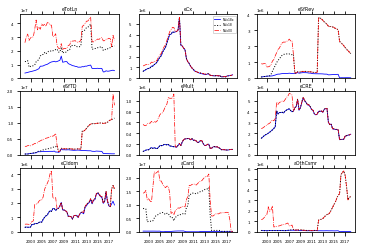

In [83]:
# assumes x18 is second grp, x00 is 1st grp, x31 is third grp:
if len(x3lst) == 3:
  xb = list(bdz3.index)
  plt.rcParams.update({'font.size': 4})

  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
    plt.plot(xb, bdz3[x3lst[2],bcc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
    plt.plot(xb, bdz3[x3lst[1],bcc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
    plt.ylim(ymin=0)
    plt.title(bcc[i],y=.97)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
    if i==1: lg = plt.legend(loc=0, fontsize=3)

    if i < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      labelbottom=labl) # labels along the bottom edge are off

  plt.savefig(grp+'_balhist3.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('skip this section')

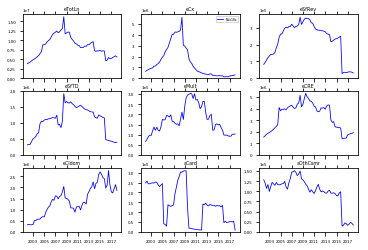

In [84]:
xb = list(bdz3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
  plt.ylim(ymin=0)
  plt.title(bcc[i],y=.97)
  plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
  if i==1: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_balhist1.png', dpi=400, bbox_inches='tight')
plt.show()

In [85]:
bdz3.tail(2)

Grp           grpC18x00                                                     \
                  aCard     aOthCsmr       eCIdom         eCRE         eCx   
AsOf                                                                         
2017-09-30  536598717.0  459265980.0  966667070.0  358426570.0  90890071.0   
2017-12-31  574202732.0  462735246.0  975964148.0  355536880.0  90743328.0   

Grp                                                                         \
                  eMult       eSfRev         eSfTD        eTotLn   rcCIdom   
AsOf                                                                         
2017-09-30  127761142.0  235695101.0  1.078760e+09  5.111147e+09  0.370921   
2017-12-31  126718787.0  229410582.0  1.089585e+09  5.197272e+09  0.353056   

Grp           ...      grpTotUSx31                                          \
              ...           eTotLn   rcCIdom     rcCRE    rcCard      rcCx   
AsOf          ...                                                            
2017-09-30    ...     3.633987e+09  0.520743  0.039510  4.664836  0.003168   
2017-12-31    ...     3.702322e+09  0.512981  0.043252  4.757333  0.006788   

Grp                                                           
              rcMult rcOthCsmr   rcSfRev    rcSfTD   rcTotLn  
AsOf                                                          
2017-09-30  0.007464  0.686624  0.059342  0.048096  0.353429  
2017-12-31  0.000437  0.688007  0.051920  0.048428  0.354414  

[2 rows x 144 columns]

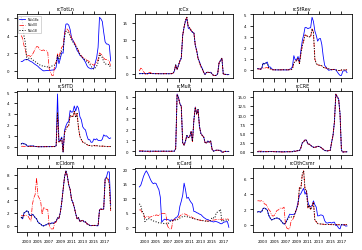

In [86]:
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohist.png', dpi=400, bbox_inches='tight')
plt.show()

In [87]:
## sections to build stress models for main group: var data in 'hs3' and 'cc3'

In [88]:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

rclst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
qclst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']

if qtyp == 1:
  curlst = qclst
elif qtyp == 4:
  curlst = rclst
else:
  curlst = []  # force error if qtyp not 1 or 4

#cbon = vtyp

In [89]:
dfc = df2_3z[df2_3z['Grp']==grp]  #  only copy requested groups in "grp"
dfc.dropna(axis=0, how='any', inplace=True)
dfc.head(2)

AsOf        Grp  IDRSSD  nbr      Cert    eTotAst     eTotLn  \
479 2001-12-31  grpNVx18x       0   27  903455.0  5753695.0  3844337.0   
480 2002-03-31  grpNVx18x       0   28  960731.0  6010931.0  4069657.0   

        eALLL   eOREO      eGW    ...         eTotrb  eALLL_Ln       mxCx  \
479  114067.0  7498.0  22660.0    ...      13.667945  2.967144  16.726525   
480  116942.0  9627.0  22660.0    ...      13.360539  2.873510  17.925221   

      mxSfFst      mxCRE      mxCI    mxCard      mxDDA    eRWA_TA   lnTotAst  
479  7.040668  40.317953  8.135239  6.820942  23.927960  71.519902  15.565353  
480  6.947244  40.636864  8.148623  6.124693  23.893471  72.706541  15.609090  

[2 rows x 320 columns]

In [90]:
## sUE_CA2 processing
st=''.join(stlst)
hs3.reset_index(drop=False,inplace=True)
hs3.head(2)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
0 2000-03-31    1.2    4.3   8.1  11.8  4.0  4.0  5.5  6.6   6.7  8.2   8.3   
1 2000-06-30    7.8   10.2   4.2   6.1  3.9  3.2  5.7  6.5   6.4  8.5   8.3   

   Prime      DJ    HPI    CRE   VIX        CE     CE_NV     UE_NV  
0    8.7  14.296  102.0  127.0  27.0  5.153778  8.821977  3.933333  
1    9.2  13.619  105.0  125.0  33.5  5.135624  8.802690  4.033333

In [91]:
## parameters for sUE calcs below (by specified CCAR year):
uex = hs3[['Date','UE']].ix[hs3['UE'].idxmax()]
ccp = cc3[['CCAR','Scen','Date','UE']].iloc[cc3.groupby(['CCAR']).apply(lambda x: x['UE'].idxmax())]

def qtn(d):
  return 4*(d.year - 2000) + d.quarter

uex['qtn'] = qtn(uex['Date'])
ccp['qtn'] = ccp.apply(lambda x: qtn(x['Date']), axis=1)

uep = uex['UE']
ccp['adz'] = uep / ccp['UE']
ccp['que'] = uex['qtn']
ccp['pdt'] = uex['Date']


In [92]:
ccps = []

## parameters for sUE_st calcs below (by specified CCAR year):
if len(stlst)>0:
  UE_st = 'UE_'+''.join(stlst)
  uexs = hs3[['Date',UE_st]].ix[hs3[UE_st].idxmax()]
  ccps = cc3[['CCAR','Scen','Date',UE_st]].iloc[cc3.groupby(['CCAR']).apply(lambda x: x[UE_st].idxmax())]

  uexs['qtn'] = qtn(uexs['Date'])
  ccps['qtn'] = ccps.apply(lambda x: qtn(x['Date']), axis=1)

  ueps = uexs[UE_st]
  ccps['adz'] = ueps / ccps[UE_st]
  ccps['que'] = uexs['qtn']
  ccps['pdt'] = uexs['Date']


In [93]:
ccps

CCAR Scen       Date      UE_NV  qtn       adz  que        pdt
21   2012  Sev 2013-06-30  18.611625   54  0.734308   44 2010-12-31
63   2013  Sev 2014-06-30  17.365543   58  0.786999   44 2010-12-31
106  2014  Sev 2015-09-30  15.942299   63  0.857258   44 2010-12-31
149  2015  Sev 2016-12-31  13.534193   68  1.009788   44 2010-12-31
191  2016  Sev 2018-03-31  14.167406   73  0.964656   44 2010-12-31
233  2017  Sev 2019-03-31  14.366422   77  0.951292   44 2010-12-31
273  2018  Sev 2019-09-30  13.556928   79  1.008095   44 2010-12-31

In [94]:
ccp

CCAR Scen       Date     UE  qtn       adz  que        pdt
21   2012  Sev 2013-06-30  13.05   54  0.758621   40 2009-12-31
63   2013  Sev 2014-06-30  12.10   58  0.818182   40 2009-12-31
105  2014  Sev 2015-06-30  11.30   62  0.876106   40 2009-12-31
147  2015  Sev 2016-06-30  10.10   66  0.980198   40 2009-12-31
189  2016  Sev 2017-09-30  10.00   71  0.990000   40 2009-12-31
231  2017  Sev 2018-09-30  10.00   75  0.990000   40 2009-12-31
273  2018  Sev 2019-09-30  10.00   79  0.990000   40 2009-12-31

In [95]:
##########################################################################################
# Date selection for desired CCAR year:
# note:  CCAR 2013 implies stress period (9q) of 2012Q4 thru 2014Q4 (altho' scenario data goes thru 2015Q4)
##########################################################################################

ccar = 2018

if ccar <= 2015:
  dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
else:
  dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)

dtend, frend

(Timestamp('2017-12-31 00:00:00'), Timestamp('2021-03-31 00:00:00'))

In [96]:
## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
ccx = cc3[cc3['CCAR'] == ccar]  # ccx contains forecast periods for selected CCAR start year
ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)  ## remove var if not included in CCAR list for this year

hsx = hs3.copy()  ## historical macrovars for this run
hsx.tail(5)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
67 2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2  4.1   3.8   
68 2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5  4.2   4.2   
69 2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3  4.0   4.0   
70 2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3  3.9   3.9   
71 2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4  4.0   3.9   

    Prime      DJ    HPI    CRE   VIX        CE     CE_NV     UE_NV  
67    3.5  23.277  184.0  269.0  22.5  4.685861  5.917100  5.400000  
68    3.8  24.508  187.0  262.0  13.1  4.733969  6.154502  5.233333  
69    4.0  25.125  190.0  272.0  16.0  4.733918  6.272925  5.100000  
70    4.3  26.149  193.0  275.0  16.0  4.735612  6.195216  4.933333  
71    4.3  27.673  194.0  279.0  13.1  4.768160  6.262914  4.900000

In [97]:
if vtyp==2:  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccp[ccp['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccp[ccp['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccp[ccp['CCAR']==ccar]['Date'])
  ueinc = (1 - ccp[ccp['CCAR']==ccar]['adz']) / (ccp[ccp['CCAR']==ccar]['qtn'] - ccp[ccp['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE'] = ccx['UE'] * ccx['uead']
  ccx['sUE2'] = ccx['sUE']**2
  if '3' in styp: ccx['sUE3'] = ccx['sUE']**3
  ccx.drop(['uead','sUE'],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE'] = hsx['UE'] * hsx['uead']
  hsx['sUE2'] = hsx['sUE'] ** 2
  if '3' in styp: hsx['sUE3'] = hsx['sUE'] ** 3
  hsx.drop(['uead','sUE'],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...      \
40  2018  Sev 2020-12-31    4.5    5.5   3.1   4.3  8.9  1.6  0.1    ...       
41  2018  Sev 2021-03-31    4.5    5.4   3.3   4.5  8.6  1.5  0.1    ...       

    Mort  Prime      DJ    HPI    CRE   VIX        CE     CE_NV      UE_NV  \
40   4.9    3.2  18.143  141.0  176.0  15.0  3.876559  3.196448  12.560953   
41   4.7    3.2  20.168  143.0  180.0  14.4  3.791752  2.596975  12.299081   

         sUE2  
40  77.915476  
41  72.751277  

[2 rows x 23 columns]

In [98]:
## sUE_st2 & sUE_st3 vars:
if (vtyp==2)&(len(stlst)>0):  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccps[ccps['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccps[ccps['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccps[ccps['CCAR']==ccar]['Date'])
  ueinc = (1 - ccps[ccps['CCAR']==ccar]['adz']) / (ccps[ccps['CCAR']==ccar]['qtn'] - ccps[ccps['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE_'+''.join(stlst)] = ccx[UE_st] * ccx['uead']
  ccx['sUE_'+''.join(stlst)+'2'] = ccx['sUE_'+''.join(stlst)]**2
  if '3' in styp: ccx['sUE_'+''.join(stlst)+'3'] = ccx['sUE_'+''.join(stlst)]**3
  ccx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE_'+''.join(stlst)] = hsx['UE_'+''.join(stlst)] * hsx['uead']
  hsx['sUE_'+''.join(stlst)+'2'] = hsx['sUE_'+''.join(stlst)] ** 2
  if '3' in styp: hsx['sUE_'+''.join(stlst)+'3'] = hsx['sUE_'+''.join(stlst)] ** 3
  hsx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m     ...      \
40  2018  Sev 2020-12-31    4.5    5.5   3.1   4.3  8.9  1.6  0.1     ...       
41  2018  Sev 2021-03-31    4.5    5.4   3.3   4.5  8.6  1.5  0.1     ...       

    Prime      DJ    HPI    CRE   VIX        CE     CE_NV      UE_NV  \
40    3.2  18.143  141.0  176.0  15.0  3.876559  3.196448  12.560953   
41    3.2  20.168  143.0  180.0  14.4  3.791752  2.596975  12.299081   

         sUE2     sUE_NV2  
40  77.915476  159.827597  
41  72.751277  153.232868  

[2 rows x 24 columns]

In [99]:
## history vars: lag (4q) vars for UE, HPI, CRE:
if vtyp > 0:
  hsx['UE_4'] = hsx['UE'].shift(4)  ## add 4q lag version of UE
  hsx['HPI_4'] = hsx['HPI'].shift(4)
  hsx['CRE_4'] = hsx['CRE'].shift(4)
  hsx['CE_4'] = hsx['CE'].shift(4)

  ccx[['UE_4','HPI_4','CRE_4','CE_4']] = ccx[['UE','HPI','CRE','CE']].shift(4)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-09-30',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-2)+'-12-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-03-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-06-30',['UE','HPI','CRE','CE']].values
  if ccar >= 2016:
    ccx.ix[ccx.Date==str(ccar)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['UE','HPI','CRE','CE']].values

  if len(stlst)>0: 
    hsx[UE_st +'_4'] = hsx[UE_st].shift(4)  ## add 4q lag version of UE
    hsx['CE_'+''.join(stlst) +'_4'] = hsx['CE_'+''.join(stlst)].shift(4)  ## add 4q lag version of UE
    ccx[UE_st+'_4'] = ccx[UE_st].shift(4)
    ccx['CE_'+''.join(stlst) +'_4'] = ccx['CE_'+''.join(stlst)].shift(4)
    if ccar <= 2015:
      ccx.ix[ccx.Date==str(ccar-1)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-2)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-12-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-03-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-03-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-06-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-06-30',[UE_st,'CE_'+''.join(stlst)]].values
    if ccar >= 2016:
      ccx.ix[ccx.Date==str(ccar)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-1)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values

  ## double check CE, cest, uest vars on boundary date bet hist and forecast (9/30/ccyr-1)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['CE']].values
  else:
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-12-31',['CE']].values

#hsx.dropna(how='any', inplace=True)
hsx.tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y    ...     \
67 2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2    ...      
68 2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5    ...      
69 2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3    ...      
70 2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3    ...      
71 2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4    ...      

       CE_NV     UE_NV       sUE2    sUE_NV2  UE_4  HPI_4  CRE_4      CE_4  \
67  5.917100  5.400000  21.773949  29.484610   5.0  175.0  254.0  4.611863   
68  6.154502  5.233333  21.762703  27.705399   4.9  177.0  245.0  4.641711   
69  6.272925  5.100000  18.206633  26.323745   4.9  179.0  248.0  4.651120   
70  6.195216  4.933333  18.197225  24.642678   4.9  182.0  266.0  4.658030   
71  6.262914  4.900000  16.535275  24.321971   4.7  184.0  269.0  4.685861   

     UE_NV_4   CE_NV_4  
67  6.400000  5.791576  
68  6.100000  5.797290  
69  5.833333  5.762974  
70  5.600000  5.834225  
71  5.400000  5.917100  

[5 rows x 28 columns]

In [100]:
ccs = ccx.copy()  # CCAR scenarios for selected year
cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
if 'No' in irflg:
  cccol = [x for x in cccol if x not in xvr] 

Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables

hsx = hsx[['Date']+cccol]  ## align var columns between hist and ccar lists (& remove forecast rows)
hsz = hsx[hsx['Date']<=frend].merge(dfc[['Grp','IDRSSD','AsOf']+curlst],\
                                    how='left',left_on='Date',right_on='AsOf') # merge hs and df data
### remove any rows with missing data:
hsz.dropna(how='any',inplace=True)
hsy = hsz[hsz['Date']<=dtend]  # cut off table at end of history: (ccar_yr-1)-09-30... use this to build models

ccs['Intercept'] = 1.0  # to set up fitting model

hsz['Intercept'] = 1.0   # to set up fitting for all available history

In [101]:
#######################################################
# 12/13/15: added new code for "big3" variables:
#######################################################
cccol3 = []
if ('Big' in irflg)|('big' in irflg):
  for i in np.arange(len(big3)):
    cccol3 = cccol3 + [x for x in cccol if big3[i] in x]
  cccol = cccol3
  Xcol = ['Intercept'] + cccol

cccol = [x for x in cccol if x[-1]!='3']
Xcol = [x for x in Xcol if x[-1]!='3']
Xcol

['Intercept',
 'rGDPg',
 'nGDPg',
 'rDIg',
 'nDIg',
 'UE',
 'CPI',
 'DJ',
 'HPI',
 'CRE',
 'VIX',
 'CE',
 'CE_NV',
 'UE_NV',
 'sUE2',
 'sUE_NV2',
 'UE_4',
 'HPI_4',
 'CRE_4',
 'CE_4',
 'UE_NV_4',
 'CE_NV_4']

In [102]:
## model:  du003edb...
## start full model here:

In [103]:
# start full model loop here:
for rc in curlst:
  eqn = rc + " ~ " + " + ".join(cccol)
  yt, Xt = dmatrices(eqn , data=hsy, return_type='dataframe')
  mod = sm.OLS(yt, Xt)
  res_tot = mod.fit()
  pred_tot = res_tot.predict(Xt)
  p_tot = res_tot.predict(ccs[Xcol])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt.rename(columns = {rc : 'Actual'}, inplace=True)
  frt['Fit'] = res_tot.predict(hsz[Xcol])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.rename(columns = {'pred' : 'Base'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'Adverse'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'SevAdv'}, inplace=True)
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()
  frt2.columns = [[rc]*len(frt.columns),frt.columns]

  prm = res_tot.params
  prm['rsq'] = res_tot.rsquared
  prm2 = pd.DataFrame(prm)
  prm2.columns = [rc]

  if rc == curlst[0]:
    frt3 = frt2.copy()
    prm3 = prm2.copy()
  else:
    frt3 = frt3.merge(frt2, how='left', left_index=True, right_index=True)
    prm3 = prm3.merge(prm2, how='left', left_index=True, right_index=True)


In [104]:
frt3.to_csv(grp + "_" + str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + styp + irflg + ".csv")
prm3.to_csv(grp + "_" + str(ccar) + "_full_param_" + str(qtyp) + "q_" + styp + irflg + ".csv")
ccar, grp, styp, irflg

(2018, 'grpNVx18x', 'Lags_sUE2', '_NoRates')

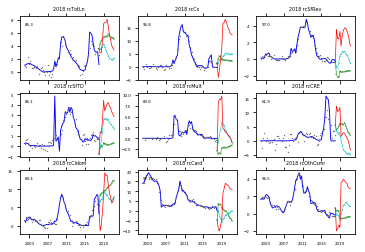

In [105]:
xax = list(frt3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
  plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
  plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
  plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=.7)
  plt.title(str(ccar)+" "+curlst[i])
  plt.annotate(str(round(prm3.ix['rsq'][curlst[i]]*100,1)), xy=(0.05, 0.86), xycoords='axes fraction', fontsize=4)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+"_"+str(ccar)+'_full'+str(qtyp) + "q_"+styp+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [106]:
prm3

rcTotLn        rcCx    rcSfRev     rcSfTD     rcMult       rcCRE  \
Intercept  84.403206  113.021571 -54.220194  15.825300 -35.586305  279.507317   
rGDPg       0.195125    0.163479   0.085328   0.131966  -0.102455    0.720589   
nGDPg      -0.213095   -0.045736  -0.043153  -0.021420   0.138130   -0.883326   
rDIg        0.352255   -0.220498  -0.047481  -0.126199   0.316262   -0.558872   
nDIg       -0.357068    0.226624   0.048450   0.153223  -0.310318    0.476388   
UE         -2.638021    1.490712   1.298788   2.328815   3.805498  -18.806289   
CPI         0.244321   -0.114270  -0.034659  -0.113661   0.148749   -0.144589   
DJ         -0.769016   -0.347829  -0.074215  -0.171620   0.104983   -2.570191   
HPI         0.000236   -0.040510   0.014798  -0.022188  -0.022899   -0.085910   
CRE        -0.015021   -0.053386  -0.001440  -0.016784  -0.006452    0.046563   
VIX        -0.046996    0.004938  -0.005181  -0.030611   0.041639   -0.142638   
CE         -4.579353   -9.633914   4.946412  -6.031485   1.699912    0.132487   
CE_NV      -1.096458   -0.774323   0.054821   1.234062   1.670830   -3.108257   
UE_NV      -3.191301   -6.148603  -0.704874  -1.633467  -0.289390    0.309494   
sUE2        0.068361   -0.253722  -0.112019  -0.302694  -0.206965    1.038174   
sUE_NV2     0.188937    0.407770   0.086591   0.150288   0.030098   -0.054813   
UE_4        0.226784   -0.140331   0.293415  -0.745785  -0.859224    2.582145   
HPI_4       0.001246    0.027945  -0.030862   0.019013   0.022939    0.034496   
CRE_4       0.056148    0.077610   0.022919   0.033988   0.030616    0.117204   
CE_4       -4.115634  -11.252457   7.180622   2.218687   0.326762  -38.570299   
UE_NV_4    -0.737421   -0.392022   0.362451   0.576748   0.767955   -2.744299   
CE_NV_4     0.267030    3.086349  -1.706073  -0.552940  -1.102286    4.173630   
rsq         0.862871    0.968030   0.970065   0.861190   0.805936    0.618930   

             rcCIdom      rcCard  rcOthCsmr    rcCREtot  
Intercept -22.861370  232.648488 -18.714435  261.273853  
rGDPg      -0.100025   -0.224806   0.148101    0.654780  
nGDPg       0.106029    0.271773  -0.099624   -0.767391  
rDIg        1.204000    0.469327  -0.129898   -0.444902  
nDIg       -1.167617   -0.478462   0.133949    0.380533  
UE          6.398189   -6.072124   0.921303  -16.428762  
CPI         0.680860    0.225605  -0.072973   -0.102915  
DJ          0.233251   -0.117891   0.003152   -2.228357  
HPI         0.085619   -0.186583   0.011885   -0.074390  
CRE        -0.065102   -0.027631   0.019745    0.021602  
VIX         0.008218    0.014633   0.009127   -0.120198  
CE         -8.702711  -35.354913   1.769290   -3.858277  
CE_NV      -0.554311    2.946143  -0.791465   -2.461330  
UE_NV      -6.859288   -6.379996  -0.387741   -0.201495  
sUE2       -0.401275    0.508338  -0.031179    0.881692  
sUE_NV2     0.390755    0.154244   0.030393   -0.008209  
UE_4       -1.370441    0.162862   0.237564    2.271055  
HPI_4       0.001725    0.004297  -0.055684    0.035295  
CRE_4       0.016293   -0.026318   0.000494    0.117881  
CE_4       19.925251    1.496601   2.612775  -33.824900  
UE_NV_4     0.086243   -0.149890  -0.090917   -2.467337  
CE_NV_4    -2.976682    1.394498   0.336345    4.081521  
rsq         0.893678    0.971013   0.965398    0.652421

In [107]:
### build 3-var models:

In [108]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [109]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'])
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [110]:
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))

In [111]:
### sections to generate forecasts for all 3-var models:

for idx, row in df3b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] # use this if using top3_rc

  if x == 0:
    frt3b = frt2.copy()
  else:
    frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)

In [112]:
frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt3s.reset_index(drop=False, inplace=True)
frt3s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
#frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn + 1
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv.head(8)

scen        rc    Actual    Adverse       Base       Fit     SevAdv      rc2  \
0     rcTotLn0  1.142680  35.446162  33.027386  2.616443  34.405856  rcTotLn   
1     rcTotLn1  1.142680  33.257490  31.565428  2.519931  31.021217  rcTotLn   
2     rcTotLn2  1.142680  33.493662  39.460171  2.691949  22.653962  rcTotLn   
3        rcCx0 -0.235510  21.500587   9.787988  0.665795  75.398126     rcCx   
4        rcCx1 -0.235510  18.912574   1.396194  0.018673  71.555818     rcCx   
5        rcCx2 -0.235510  10.451793  26.084080  2.100663  60.409008     rcCx   
6     rcSfRev0 -0.251799   5.006938  -6.390017 -0.728855  18.212892  rcSfRev   
7     rcSfRev1 -0.251799  -0.625209 -13.014439 -0.926637  12.611966  rcSfRev   

scen  ord       diff  rk  
0       0  34.405856   1  
1       0  31.021217   2  
2       0  22.653962   3  
3       1  75.398126   1  
4       1  71.555818   2  
5       1  60.409008   3  
6       2  18.212892   1  
7       2  12.611966   2

In [113]:
df3bc = df3b.copy()
df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df3bc['rc'] = df3bc.index % topn
df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df3bc.reset_index(drop=True, inplace=True)
df3bc.index.names = [grp+"_"+str(ccar)+"_"+styp]
df3bc.tail()

rc2     v1        r1       v2        r2  \
grpNVx18x_2018_Lags_sUE2                                                  
25                        rcOthCsmr   sUE2  0.735222  CE_NV_4  0.878197   
26                        rcOthCsmr   sUE2  0.735222     CE_4  0.892867   
27                         rcCREtot  CE_NV  0.183722    CRE_4  0.239610   
28                         rcCREtot     CE  0.169562    CRE_4  0.251642   
29                         rcCREtot  CE_NV  0.183722    CRE_4  0.239610   

                             v3        r3       Int        c1        c2  \
grpNVx18x_2018_Lags_sUE2                                                  
25                          HPI  0.916139  0.361139  0.041599  0.204744   
26                        HPI_4  0.914394 -5.056499  0.050447  1.169647   
27                          CRE  0.259245  2.009468 -0.495564  0.046060   
28                          CRE  0.257427  8.979256 -2.376971  0.043898   
29                           DJ  0.257314  2.465540 -0.639142  0.034328   

                                c3          rc  ord  rk  
grpNVx18x_2018_Lags_sUE2                                 
25                       -0.014820  rcOthCsmr1    8   2  
26                       -0.009332  rcOthCsmr2    8   3  
27                       -0.026275   rcCREtot0    9   1  
28                       -0.020063   rcCREtot1    9   2  
29                       -0.161703   rcCREtot2    9   3

In [114]:
frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2018

In [115]:
rnk = 1  ## 1 to topn

df_bst = df3bc[df3bc['rk']== rnk][['rc','v1','v2','v3','r3']]
df_bst.dropna(how='any', inplace=True)
df_bst.reset_index(drop=True, inplace=True)

def vlst(x):
  lst = [x['v1'],x['v2'],x['v3'],str(round(x['r3']*100,1))]
  return ';'.join(lst)

df_bst['var'] = df_bst.apply(vlst, axis=1)
dflst = list(df_bst['var'])
#dflst2 = [dflst[i] for i in grord]
dflst

['CE;UE_NV_4;sUE_NV2;50.5',
 'sUE_NV2;UE_NV;UE_4;91.4',
 'sUE_NV2;DJ;sUE2;90.8',
 'sUE_NV2;sUE2;CPI;70.9',
 'VIX;UE_NV;rGDPg;58.6',
 'CE_NV_4;CRE_4;UE_NV_4;21.1',
 'sUE_NV2;UE_NV_4;CE_NV_4;59.6',
 'CRE;UE_NV_4;HPI_4;85.6',
 'sUE2;CE_4;HPI;92.3',
 'CE_NV;CRE_4;CRE;25.9']

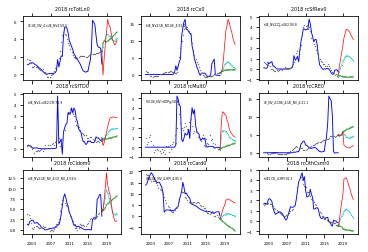

In [116]:
plt.rcParams.update({'font.size': 4})

#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='+',mew=.25,ms=1.2,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [117]:
grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png'

'grpNVx18x_2018_4q_3v9n_Lags_sUE2_3rk1_NoRates.png'

In [118]:
frt3b.ix[:'2012-09-30'][df_bst.ix[i]['rc'],'Actual'][-4:]

Date
2011-12-31    3.096778
2012-03-31    2.599851
2012-06-30    2.298321
2012-09-30    1.166160
Name: (rcOthCsmr0, Actual), dtype: float64

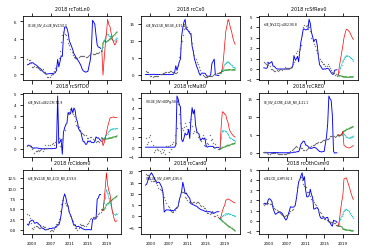

In [119]:
# alt version cuts off act and fit before 1st CCAR forecast period
plt.rcParams.update({'font.size': 4})
xaz=list(frt3b.ix[:str(ccar-1)+'-09-30'].index)
#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='+',mew=.25,ms=1.2,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'alt.png', dpi=400, bbox_inches='tight')
plt.show()

In [120]:
df3lst = []
for i in np.arange(len(df3bc)):
  ds = df3bc.ix[i]['v1'] + ', ' + df3bc.ix[i]['v2'] + ', ' + df3bc.ix[i]['v3'] +\
         ': '+ str(round(df3bc.ix[i]['r3']*100,1))
  df3lst = df3lst + [ds]

df3bc['Annot'] = df3lst
df3bc[0:2]

rc2  v1        r1       v2        r2       v3  \
grpNVx18x_2018_Lags_sUE2                                                      
0                         rcTotLn  CE  0.307395  UE_NV_4  0.418765  sUE_NV2   
1                         rcTotLn  CE  0.307395  UE_NV_4  0.418765     sUE2   

                                r3        Int        c1        c2        c3  \
grpNVx18x_2018_Lags_sUE2                                                      
0                         0.505297  25.194029 -4.107442 -0.632239  0.017328   
1                         0.461430  25.214415 -4.245570 -0.523459  0.022724   

                                rc  ord  rk                       Annot  
grpNVx18x_2018_Lags_sUE2                                                 
0                         rcTotLn0    0   1  CE, UE_NV_4, sUE_NV2: 50.5  
1                         rcTotLn1    0   2     CE, UE_NV_4, sUE2: 46.1

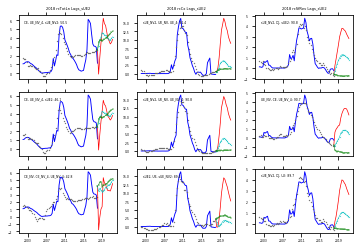

In [121]:
## top3 3-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

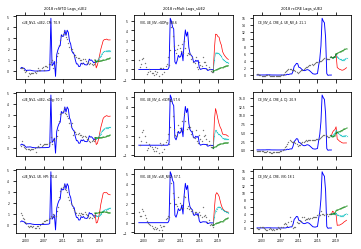

In [122]:
## top3 3-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

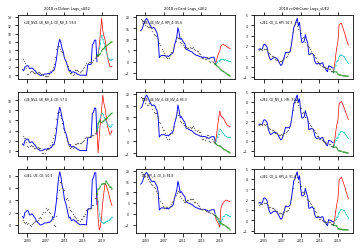

In [123]:
## top3 3-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [124]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v,\
                       data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [125]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 2-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 3-var models
df4b.index = np.arange(len(df4b))

In [126]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names

  if x == 0:
    frt4b = frt2.copy()
  else:
    frt4b = frt4b.merge(frt2, how='outer', left_index=True, right_index=True)

In [127]:
frt2.head()

rcTotLn2                              
              Actual       Fit Base Adverse SevAdv
Date                                              
2001-12-31  1.069809  1.772466  NaN     NaN    NaN
2002-03-31  1.095592  1.505641  NaN     NaN    NaN
2002-06-30  1.240049  1.327986  NaN     NaN    NaN
2002-09-30  1.289468  0.975817  NaN     NaN    NaN
2002-12-31  1.304238  0.264294  NaN     NaN    NaN

In [128]:
frt4s = pd.DataFrame(frt4b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt4s.reset_index(drop=False, inplace=True)
frt4s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt4s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
####################################################################
#   NOTE:  this section will determine ordering of models in charts:
#          3 options: (1) r-sq, (2) SevAdv, or (3) differential bet SevAdv and Base
#frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv['diff'] = frpv.apply(lambda x: x['SevAdv']-max(0,x['Base']),axis=1)
#frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
####################################################################
frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True) # use for diff = SevAdv or SevAdv-Base
#frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
####################################################################
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.tail(9)

scen          rc    Actual    Adverse       Base       Fit     SevAdv  \
22       rcCard0  0.021880  -5.633457 -30.917374 -1.012345  27.318942   
21       rcCard1  0.021880   6.277497 -22.089800 -0.633795  45.317345   
23       rcCard2  0.021880 -37.242236 -27.746381  0.342622 -33.028192   
24    rcOthCsmr0 -0.120394   2.791697  -2.339874 -0.153068  20.327046   
25    rcOthCsmr1 -0.120394   1.264600  -3.041558 -0.212004  18.863171   
26    rcOthCsmr2 -0.120394   5.974508  -2.366809 -0.311511  18.879251   
27     rcCREtot0 -0.038315  38.869146  19.251773  2.479045  59.434922   
28     rcCREtot1 -0.038315  46.543759  34.526343  4.345013  55.638409   
29     rcCREtot2 -0.038315  47.934794  37.657533  4.417718  55.171692   

scen        rc2  ord       diff  rk  
22       rcCard    7  58.236317   1  
21       rcCard    7  67.407145   0  
23       rcCard    7  -5.281811   2  
24    rcOthCsmr    8  22.666920   0  
25    rcOthCsmr    8  21.904729   1  
26    rcOthCsmr    8  21.246060   2  
27     rcCREtot    9  40.183149   0  
28     rcCREtot    9  21.112066   1  
29     rcCREtot    9  17.514159   2

In [129]:
df4bc = df4b.copy()
df4bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df4bc['rc'] = df4bc.index % topn
df4bc['rc'] = df4bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df4bc = df4bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df4bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df4bc.reset_index(drop=True, inplace=True)
df4bc['Desc'] = grp+"_"+str(ccar)+"_4v9"+styp
df4bc.tail(9)

rc2     v1        r1       v2        r2     v3        r3     v4  \
21     rcCard    CRE  0.725467  UE_NV_4  0.819031  HPI_4  0.856424   UE_4   
22     rcCard    CRE  0.725467  UE_NV_4  0.819031  HPI_4  0.856424   sUE2   
23     rcCard     DJ  0.524998    HPI_4  0.707943   CE_4  0.847646   UE_4   
24  rcOthCsmr   sUE2  0.735222     CE_4  0.892867    HPI  0.922923     UE   
25  rcOthCsmr   sUE2  0.735222  CE_NV_4  0.878197    HPI  0.916139     UE   
26  rcOthCsmr   sUE2  0.735222     CE_4  0.892867  HPI_4  0.914394  CE_NV   
27   rcCREtot  CE_NV  0.183722    CRE_4  0.239610     DJ  0.257314   CE_4   
28   rcCREtot  CE_NV  0.183722    CRE_4  0.239610    CRE  0.259245   CE_4   
29   rcCREtot     CE  0.169562    CRE_4  0.251642    CRE  0.257427   CE_4   

          r4        Int        c1        c2         c3        c4          rc  \
21  0.868134  42.358907 -0.053391 -1.691783  -0.147350  1.653839     rcCard0   
22  0.867343  46.041520 -0.048676 -1.153422  -0.151101  0.056624     rcCard1   
23  0.866790 -36.362603  0.615354 -0.311271  15.034660  1.383001     rcCard2   
24  0.934398   2.776778  0.123199  0.864513  -0.021316 -1.190885  rcOthCsmr0   
25  0.932140   6.784652  0.131271  0.167237  -0.023678 -1.356903  rcOthCsmr1   
26  0.931147  -7.136812  0.043621  2.164596  -0.013839 -0.238337  rcOthCsmr2   
27  0.286398  22.723709  0.497404  0.071455  -0.424186 -6.582060   rcCREtot0   
28  0.276409  16.574410  0.527913  0.085273  -0.055057 -4.932560   rcCREtot1   
29  0.275543   9.097627  2.190015  0.084507  -0.058745 -4.580735   rcCREtot2   

    ord  rk                         Desc  
21    7   1  grpNVx18x_2018_4v9Lags_sUE2  
22    7   0  grpNVx18x_2018_4v9Lags_sUE2  
23    7   2  grpNVx18x_2018_4v9Lags_sUE2  
24    8   0  grpNVx18x_2018_4v9Lags_sUE2  
25    8   1  grpNVx18x_2018_4v9Lags_sUE2  
26    8   2  grpNVx18x_2018_4v9Lags_sUE2  
27    9   0  grpNVx18x_2018_4v9Lags_sUE2  
28    9   1  grpNVx18x_2018_4v9Lags_sUE2  
29    9   2  grpNVx18x_2018_4v9Lags_sUE2

In [130]:
frt4b.to_csv(grp + "_"  + str(ccar) +'_4v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df4bc.to_csv(grp + "_"  + str(ccar) + '_4v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2018

In [131]:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(df4bc)):
  ds1 = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', ' + df4bc.ix[i]['v3'] + ','
  ds2 = df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

df4bc['Annot1'] = df4lst1
df4bc['Annot2'] = df4lst2
df4bc[0:2]

rc2  v1        r1       v2        r2       v3        r3     v4  \
0  rcTotLn  CE  0.307395  UE_NV_4  0.418765  sUE_NV2  0.505297  UE_NV   
1  rcTotLn  CE  0.307395  UE_NV_4  0.418765     sUE2  0.461430     UE   

         r4        Int        c1        c2        c3        c4        rc  ord  \
0  0.641180  45.465526 -6.476053 -0.747466  0.119223 -1.973490  rcTotLn0    0   
1  0.602322  36.304679 -3.925489 -0.357516  0.300709 -4.073588  rcTotLn1    0   

   rk                         Desc                 Annot1       Annot2  
0   1  grpNVx18x_2018_4v9Lags_sUE2  CE, UE_NV_4, sUE_NV2,  UE_NV: 64.1  
1   2  grpNVx18x_2018_4v9Lags_sUE2     CE, UE_NV_4, sUE2,     UE: 60.2

In [132]:
##################################################################################
# select highest R-squared model:
#md = [0,0,0,0,0,0,0,0,0]  # note: use this to rank based on R-squared
#mdr = [x for x in list(df4bc['rc']) if x[-1]=='0']

# special code to select "best" model based on max 9q diff between SevAdv and Base forecasts:
md=list(df4bc[df4bc['rk']==0]['rc'])  # note: use this if you want models based on diff calc (SevAdv - Bas ranking)
mdr = [x[-1] for x in md]

mdr, md

(['2', '1', '2', '0', '1', '1', '2', '1', '0', '0'],
 ['rcTotLn2',
  'rcCx1',
  'rcSfRev2',
  'rcSfTD0',
  'rcMult1',
  'rcCRE1',
  'rcCIdom2',
  'rcCard1',
  'rcOthCsmr0',
  'rcCREtot0'])

In [133]:
curlst

['rcTotLn',
 'rcCx',
 'rcSfRev',
 'rcSfTD',
 'rcMult',
 'rcCRE',
 'rcCIdom',
 'rcCard',
 'rcOthCsmr',
 'rcCREtot']

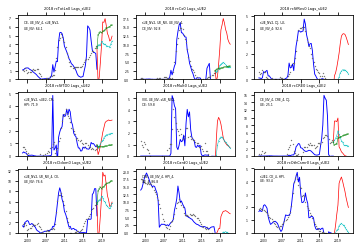

In [134]:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

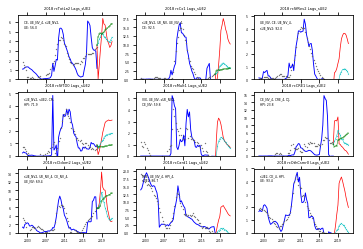

In [135]:
## special version for TotUSx18 only... best version based on diff bet SevAdv and Base:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

#ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

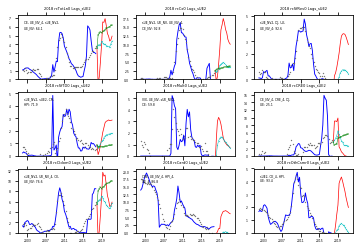

In [136]:
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

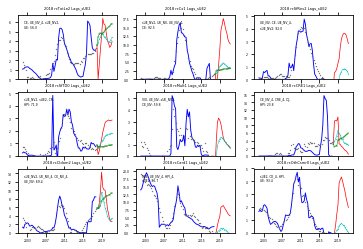

In [137]:
## special version for 2013 TotUSx18 only... best diff sevadv - base (9q only)
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.ylim(ymin=0)

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = 'off'
  else:
    labl = 'on'

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

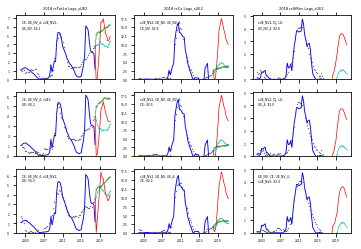

In [138]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

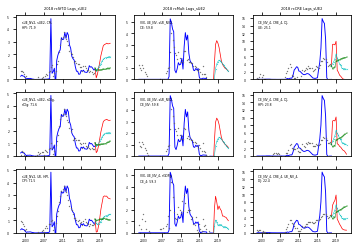

In [139]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

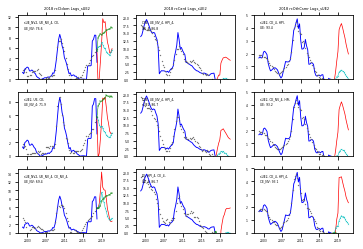

In [140]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(ymin=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [141]:
## repeat triple charts cutting off actual and fitted to prior Sept (9/30/2012 for 2013 CCAR)

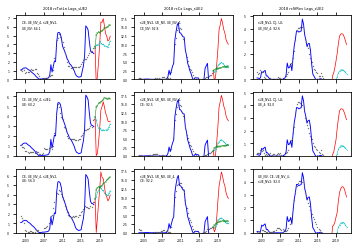

In [142]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

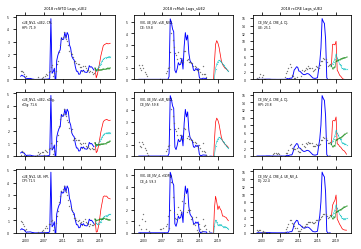

In [143]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

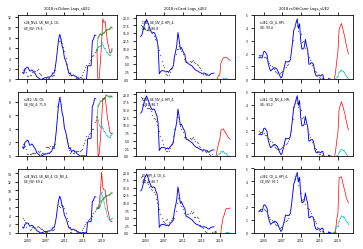

In [144]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(ymin=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = 'off'
    else:
      labl = 'on'

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [145]:
## section to calculate volumes of NCOs from the forecasted NCO rates:

In [146]:
nmlst = ['qncTotLn','qncCx','qncSfRev','qncSfTD','qncMult','qncCRE','qncCIdom','qncCard','qncOthCsmr','qncCREtot'] # numerators in vofi
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] # denominators in vofi

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
svm = "SevAdv"  ######### changed on 12/8/15 from sm to svm to avoid statsmodels abbreviation

In [147]:
grporig, styp, irflg

('grpNVx18x', 'Lags_sUE2', '_NoRates')

In [148]:
## volumes file:
vofi = "df2_3z_"+grporig+".csv"            ## history volumes file for groups to analyze
vo = pd.read_csv(vofi, index_col=0)
vo = vo[vo['Grp']==grp]
vo.rename(columns={"AsOf":"Date"}, inplace=True)
vo['Date'] = pd.to_datetime(vo['Date'])
vo.set_index('Date',drop=True,inplace=True)

dfz1 = []
dfz3 = []

In [149]:
#vv = 2  ## 0,1,2 only:  selects vlst item

#mn = 1 # single models per rc ("full" files)
#mn = 3 # 3 vars per rc ("3v" files)
mn = 4 # 4 vars per rc ("4v" files)

#rkfi = pd.read_csv(grp+'_allyr_' + str(rtyp) +'_'+str(mn)+'v10best_'+cbo[vv]+'.csv', index_col=0)
#rkfi.set_index('ccar',drop=True, inplace=True)

In [150]:
if ccar <= 2015:
  dttr = str(ccar-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar-1) + "-12-31"  # start of 9q forecast period
  dten = str(ccar+1) + "-12-31"  # end of 9q forecast period
else:
  dttr = str(ccar-1) + "-12-31"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar) + "-03-31"  # start of 9q forecast period
  dten = str(ccar+2) + "-03-31"  # end of 9q forecast period

if ccar >= 2016: 
  vo = vo.ix[:dttr]  # special handling for CCAR years after 2015
else:
  vo = vo.ix[:"2014-12-31"]  # conforms to book exhibits

if mn == 1:
  mtyp = '_full_'
elif mn == 3:
  mtyp = '_3v_'
elif mn == 4:
  mtyp = '_4v_'
else:
  mtyp = 'xxx'  # force error to fix problem
  
hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
  
rtfi = grp + "_" + str(ccar) + mtyp + "9fcst_" + rtyp +"_" + styp +irflg + ".csv" ## file with modeled ccar forecast nco/fail rates
rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
  
paramfi = grp + "_" + str(ccar) + mtyp + "9param_" + rtyp +"_"  + styp +irflg + ".csv"  ## param file for same run
param = pd.read_csv(paramfi, index_col=0, header=0)
param.index.name= 'scen'
  
### start prod loops here:
balst= []
dmlst = []

In [151]:
param.head(2)

rc2  v1        r1       v2        r2       v3        r3     v4  \
scen                                                                       
0     rcTotLn  CE  0.307395  UE_NV_4  0.418765  sUE_NV2  0.505297  UE_NV   
1     rcTotLn  CE  0.307395  UE_NV_4  0.418765     sUE2  0.461430     UE   

            r4        Int        c1        c2        c3        c4        rc  \
scen                                                                          
0     0.641180  45.465526 -6.476053 -0.747466  0.119223 -1.973490  rcTotLn0   
1     0.602322  36.304679 -3.925489 -0.357516  0.300709 -4.073588  rcTotLn1   

      ord  rk                         Desc  
scen                                        
0       0   1  grpNVx18x_2018_4v9Lags_sUE2  
1       0   2  grpNVx18x_2018_4v9Lags_sUE2

In [152]:
#for pr in np.arange(2):
for pr in np.arange(len(rt.columns.levels[0])):
  if mn > 1:
    prn = rclst[int(pr/topn)]+str(pr % topn)  # add rank suffix to prodname
  else:
    prn = rclst[int(pr/topn)]    ## just use prodname
  prnm = rclst[int(pr/topn)]     ## prod name (no rank suffix)
  drt = rt[prn]
  df = vo[[nmz[prnm],dmz[prnm]]]
  df.columns = ['nco','bal']
  
  dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
  
  # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
  dfr['Fv'] = dfr['nco']  # added 12/12
  dfr['Bv'] = dfr['nco']
  dfr['Av'] = dfr['nco']
  dfr['Sv'] = dfr['nco']
  
  dfr['bal'] = dfr['bal'].fillna(method='pad')
  dfr[[bm,am,svm]] = dfr[[bm,am,svm]].fillna(-999)
  
  dfr.ix[dttr][bm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][bm] == -999:
      dfr.ix[x][bv] = dfr.ix[x].nco
      dfr.ix[x][fv] = dfr.ix[x].nco # added 12/12
    else:
      if rtyp == "4q":
        dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
        dfr.ix[x][fv] = dfr.ix[x][fm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][fv] +dfr.ix[x-2][fv] +dfr.ix[x-3][fv])  # added 12/12
      else:
        dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
        dfr.ix[x][fv] = dfr.ix[x][fm] * dfr.ix[x].bal/400  # added 12/12
  
  dfr.ix[dttr][am] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][am] == -999:
      dfr.ix[x][av] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
      else:
        dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
  
  dfr.ix[dttr][svm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][svm] == -999:
      dfr.ix[x][sv] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][sv] = dfr.ix[x][svm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
      else:
        dfr.ix[x][sv] = dfr.ix[x][svm] * dfr.ix[x].bal/400 
  
  ## NEW SECTION:
  dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
  for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
    if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
      if np.isnan(dfr.ix[i]['Adverse']):
        dfr.ix[i]['Av'] = np.nan
  
  dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv) 
  
  r9q = pd.rolling_sum(dfr['2006-12-31':dtst]['nco'],window=9, min_periods=9)
  r9q = r9q.dropna()
  r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
  
  dfv2 = pd.DataFrame(dfv, columns=[prn])
  dfv2.ix['ActMx'] = r9qm.values[0]
  dfv2.ix['DateMx'] = r9qm.index[0]
  dfv2t = dfv2.T
  dfv2t.reset_index(drop=False, inplace=True)
  
  b9q = pd.rolling_mean(dfr['2006-12-31':dtst]['bal'],window=9, min_periods=9)
  balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
  
  dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
#  voldet = dfr.ix[str(ccar-1)+'-01-01':]
  voldet = dfr.ix[str(ccar-3)+'-01-01':]
  voldet.columns = pd.MultiIndex.from_product([[prn], list(voldet.columns)])
  
  if pr == 0:
    dfvr = dfv2t
    voldet2 = voldet.copy()
  else:
    dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
#    voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    voldet2 = pd.concat([voldet,voldet2],ignore_index=True,axis=1)

In [153]:
dfvr

index       Bv       Av       Sv        ActMx               DateMx
0     rcTotLn0   860747   603537   565932  1.04039e+06  2010-12-31 00:00:00
1     rcTotLn1   847957   437613   440193  1.04039e+06  2010-12-31 00:00:00
2     rcTotLn2   764902   644518   522484  1.04039e+06  2010-12-31 00:00:00
3        rcCx0  30643.3  34270.1  91599.8       490908  2010-12-31 00:00:00
4        rcCx1  26214.4  32425.4  90680.8       490908  2010-12-31 00:00:00
5        rcCx2    27591  28802.9    90994       490908  2010-12-31 00:00:00
6     rcSfRev0 -836.498  181.408  1977.85        29443  2011-09-30 00:00:00
7     rcSfRev1 -772.328  236.357  2009.34        29443  2011-09-30 00:00:00
8     rcSfRev2 -1015.64  116.362  1931.49        29443  2011-09-30 00:00:00
9      rcSfTD0  6704.71  12079.3  16838.8       113942  2011-12-31 00:00:00
10     rcSfTD1  8952.45  13363.9  17903.6       113942  2011-12-31 00:00:00
11     rcSfTD2  10108.8  9498.28  16940.3       113942  2011-12-31 00:00:00
12     rcMult0 -2403.86   3053.3  5480.56        14922  2010-06-30 00:00:00
13     rcMult1 -2671.68  2909.53  5425.81        14922  2010-06-30 00:00:00
14     rcMult2 -1400.21  1913.36  6053.53        14922  2010-06-30 00:00:00
15      rcCRE0   247568   240196   225766       351851  2016-03-31 00:00:00
16      rcCRE1   225966   255042   271442       351851  2016-03-31 00:00:00
17      rcCRE2   294969   279970   227741       351851  2016-03-31 00:00:00
18    rcCIdom0   434617   276895   263795       283216  2017-12-31 00:00:00
19    rcCIdom1   400957   173611   197970       283216  2017-12-31 00:00:00
20    rcCIdom2   361423   279818   355908       283216  2017-12-31 00:00:00
21     rcCard0 -1058.37 -40.1301  1198.89        34472  2009-06-30 00:00:00
22     rcCard1 -742.738  311.011   1682.6        34472  2009-06-30 00:00:00
23     rcCard2 -645.815 -893.773 -1682.57        34472  2009-06-30 00:00:00
24  rcOthCsmr0  -144.07  182.823  1256.53        10064  2010-09-30 00:00:00
25  rcOthCsmr1 -192.981  100.847  1193.93        10064  2010-09-30 00:00:00
26  rcOthCsmr2 -136.662  384.794  1174.05        10064  2010-09-30 00:00:00
27   rcCREtot0   153959   266509   391415       720964  2010-12-31 00:00:00
28   rcCREtot1   270309   326998   346449       720964  2010-12-31 00:00:00
29   rcCREtot2   291826   335075   337515       720964  2010-12-31 00:00:00

In [154]:
voldet.head(2)

rcCREtot2                                                     \
                 nco        bal    Actual       Fit Base Adverse SevAdv   
Date                                                                      
2015-03-31   52427.0  2745397.0  2.015442  2.183425  NaN     NaN    NaN   
2015-06-30   40877.0  2729217.0  3.601241  2.691806  NaN     NaN    NaN   

                                                
                 Fv       Bv       Av       Sv  
Date                                            
2015-03-31  52427.0  52427.0  52427.0  52427.0  
2015-06-30  40877.0  40877.0  40877.0  40877.0

In [155]:
if mn > 1:
  dfvr2 = dfvr.copy()
  dfvr2['bal'] = dmlst
  dfvr2['ActBalMx'] = balst
  dfvr2['rk']  = dfvr2.index % mn
  dfvr2['rk'] += 1
  
  dfvr2t = dfvr2.copy()
  dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/(dfvr2t['ActBalMx']+.000001)
  dfvr2t['ModRt'] = dfvr2t['Sv']*100/(dfvr2t['bal']+.000001)
  dfvr2t = dfvr2t[['index','bal','Bv','Av','Sv','ActMx','ActBalMx','DateMx','ActMxRt','ModRt']] # chgd 12/12 'Fv'
  dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
  dfvr2t['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp + styp
  dfvr2t.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_vol.csv")
  voldet2.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_voldet.csv")
  dfz3 = dfvr2t.copy()
  
if mn == 1:
  dfvr['bal'] = dmlst
  dfvr['ActBalMx'] = balst
  dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
  
  dfvrt = dfvr.copy()
  dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
  dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
  dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
  dfvrt['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp +"_"+ styp
  dfvrt.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv")
  voldet.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_voldet.csv")
  dfz1 = dfvrt.copy()

In [156]:
voldet.tail()

rcCREtot2                                                          \
                 nco        bal Actual Fit      Base   Adverse    SevAdv  Fv   
Date                                                                           
2020-03-31       NaN  2357248.0    NaN NaN  4.964952  4.224049  2.908594 NaN   
2020-06-30       NaN  2357248.0    NaN NaN  5.044555  4.253701  2.597596 NaN   
2020-09-30       NaN  2357248.0    NaN NaN  5.283562  4.286485  2.583394 NaN   
2020-12-31       NaN  2357248.0    NaN NaN  5.458774  4.365952  2.491300 NaN   
2021-03-31       NaN  2357248.0    NaN NaN  5.517222  4.338145  2.320368 NaN   

                                                      
                      Bv            Av            Sv  
Date                                                  
2020-03-31  74687.362866  56784.016691  11301.047425  
2020-06-30  21198.256875  19294.115892  17465.376958  
2020-09-30   7185.544254   1659.909359   8033.285156  
2020-12-31  25605.668203  25178.280888  21926.404173  
2021-03-31  76065.126694  56128.535060   7271.753138

In [157]:
grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv"

'grpNVx18x_2018_4v_4q_Lags_sUE2_NoRates_vol.csv'

In [158]:
grp = grporig  # reset to original grp designation
grp, styp, irflg, ccar

('grpNVx18x', 'Lags_sUE2', '_NoRates', 2018)